______________________________________________________
# Soldier Race Classification Project
______________________________________________________



# EDA


## Import Libraries

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pyforest
import plotly
import cufflinks as cf

#Enabling the offline mode for interactive plotting locally
from plotly.offline import download_plotlyjs,init_notebook_mode,plot,iplot
init_notebook_mode(connected=True)
cf.go_offline()

#To display the plots
%matplotlib inline
plt.rcParams["figure.figsize"] = (10,6)

import warnings
warnings.filterwarnings('ignore')
warnings.warn("this will not show")

pd.set_option('display.float_format', lambda x: '%.3f' % x)

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.metrics import make_scorer
from sklearn.metrics import classification_report,confusion_matrix,plot_confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [37]:
def plot_multiclass_roc(clf, X_test, y_test, n_classes, figsize=(5,5)):
    y_score = clf.decision_function(X_test)

    # structures
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # calculate dummies once
    y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # roc for each class
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic example')
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for label %i' % (roc_auc[i], i))
    ax.legend(loc="best")
    ax.grid(alpha=.4)
    sns.despine()
    plt.show()

In [38]:
def plot_multiclass_roc_for_tree(clf, X_test, y_test, n_classes, figsize=(5,5)):
    y_score = clf.predict_proba(X_test)

    # structures
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # calculate dummies once
    y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # roc for each class
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic example')
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for label %i' % (roc_auc[i], i))
    ax.legend(loc="best")
    ax.grid(alpha=.4)
    sns.despine()
    plt.show()

## Ingest Data from links below and make a dataframe
- Soldiers Male : https://query.data.world/s/h3pbhckz5ck4rc7qmt2wlknlnn7esr
- Soldiers Female : https://query.data.world/s/sq27zz4hawg32yfxksqwijxmpwmynq

In [39]:
df_male = pd.read_csv('https://query.data.world/s/h3pbhckz5ck4rc7qmt2wlknlnn7esr',
                      encoding='latin-1')

In [40]:
df_female = pd.read_csv('https://query.data.world/s/sq27zz4hawg32yfxksqwijxmpwmynq',
                      encoding='latin-1')

In [41]:
df_male.head()

,subjectid,abdominalextensiondepthsitting,acromialheight,acromionradialelength,anklecircumference,axillaheight,balloffootcircumference,balloffootlength,biacromialbreadth,bicepscircumferenceflexed,bicristalbreadth,bideltoidbreadth,bimalleolarbreadth,bitragionchinarc,bitragionsubmandibulararc,bizygomaticbreadth,buttockcircumference,buttockdepth,buttockheight,buttockkneelength,buttockpopliteallength,calfcircumference,cervicaleheight,chestbreadth,chestcircumference,chestdepth,chestheight,crotchheight,crotchlengthomphalion,crotchlengthposterioromphalion,earbreadth,earlength,earprotrusion,elbowrestheight,eyeheightsitting,footbreadthhorizontal,footlength,forearmcenterofgriplength,forearmcircumferenceflexed,forearmforearmbreadth,forearmhandlength,functionalleglength,handbreadth,handcircumference,handlength,headbreadth,headcircumference,headlength,heelanklecircumference,heelbreadth,hipbreadth,hipbreadthsitting,iliocristaleheight,interpupillarybreadth,interscyei,interscyeii,kneeheightmidpatella,kneeheightsitting,lateralfemoralepicondyleheight,lateralmalleolusheight,lowerthighcircumference,mentonsellionlength,neckcircumference,neckcircumferencebase,overheadfingertipreachsitting,palmlength,poplitealheight,radialestylionlength,shouldercircumference,shoulderelbowlength,shoulderlength,sittingheight,sleevelengthspinewrist,sleeveoutseam,span,stature,suprasternaleheight,tenthribheight,thighcircumference,thighclearance,thumbtipreach,tibialheight,tragiontopofhead,trochanterionheight,verticaltrunkcircumferenceusa,waistbacklength,waistbreadth,waistcircumference,waistdepth,waistfrontlengthsitting,waistheightomphalion,weightkg,wristcircumference,wristheight,Gender,Date,Installation,Component,Branch,PrimaryMOS,SubjectsBirthLocation,SubjectNumericRace,Ethnicity,DODRace,Age,Heightin,Weightlbs,WritingPreference
0,10027,266,1467,337,222,1347,253,202,401,369,274,493,71,319,291,142,979,240,882,619,509,373,1535,291,1074,259,1292,877,607,351,36,71,19,247,802,101,273,349,299,575,477,1136,90,214,193,150,583,206,326,70,332,366,1071,685,422,441,502,560,500,77,391,118,400,436,1447,113,437,273,1151,368,145,928,883,600,1782,1776,1449,1092,610,164,786,491,140,919,1700,501,329,933,240,440,1054,815,175,853,Male,4-Oct-10,Fort Hood,Regular Army,Combat Arms,19D,North Dakota,1,NaN,1,41,71,180,Right hand
1,10032,233,1395,326,220,1293,245,193,394,338,257,479,67,344,320,135,944,232,870,584,468,357,1471,269,1021,253,1244,851,615,376,33,62,18,232,781,98,263,348,289,523,476,1096,86,203,195,146,568,201,334,72,312,356,1046,620,441,447,490,540,488,73,371,131,380,420,1380,118,417,254,1119,353,141,884,868,564,1745,1702,1387,1076,572,169,822,476,120,918,1627,432,316,870,225,371,1054,726,167,815,Male,4-Oct-10,Fort Hood,Regular Army,Combat Support,68W,New York,1,NaN,1,35,68,160,Left hand
2,10033,287,1430,341,230,1327,256,196,427,408,261,544,75,345,330,135,1054,258,901,623,506,412,1501,288,1120,267,1288,854,636,359,40,61,23,237,810,103,270,355,357,575,491,1115,93,220,203,148,573,202,356,70,349,393,1053,665,462,475,496,556,482,72,409,123,403,434,1447,121,431,268,1276,367,167,917,910,604,1867,1735,1438,1105,685,198,807,477,125,918,1678,472,329,964,255,411,1041,929,180,831,Male,4-Oct-10,Fort Hood,Regular Army,Combat Support,68W,New York,2,NaN,2,42,68,205,Left hand
3,10092,234,1347,310,230,1239,262,199,401,359,262,518,73,328,309,143,991,242,821,560,437,395,1423,296,1114,262,1205,769,590,341,39,66,25,272,794,106,267,352,318,593,467,1034,91,217,194,158,576,199,341,68,338,367,986,640,458,461,460,511,452,76,393,106,407,446,1357,118,393,249,1155,330,148,903,848,550,1708,1655,1346,1021,604,180,803,445,127,847,1625,461,315,857,205,399,968,794,176,793,Male,12-Oct-10,Fort Hood,Regular Army,Combat Service Support,88M,Wisconsin,1,NaN,1,31,66,175,Right hand
4,10093,250,1585,372,247,1478,267,224,435,356,263,524,80,340,310,138,1029,275,1080,706,567,425,1684,304,1048,232,1452,1014,682,382,32,56,19,188,814,111,305,399,324,605,550,1279,94,222,218,153,566,197,374,69,332,372,1251,675,481,505,612,666,585,85,458

In [42]:
df_female.head()

,SubjectId,abdominalextensiondepthsitting,acromialheight,acromionradialelength,anklecircumference,axillaheight,balloffootcircumference,balloffootlength,biacromialbreadth,bicepscircumferenceflexed,bicristalbreadth,bideltoidbreadth,bimalleolarbreadth,bitragionchinarc,bitragionsubmandibulararc,bizygomaticbreadth,buttockcircumference,buttockdepth,buttockheight,buttockkneelength,buttockpopliteallength,calfcircumference,cervicaleheight,chestbreadth,chestcircumference,chestdepth,chestheight,crotchheight,crotchlengthomphalion,crotchlengthposterioromphalion,earbreadth,earlength,earprotrusion,elbowrestheight,eyeheightsitting,footbreadthhorizontal,footlength,forearmcenterofgriplength,forearmcircumferenceflexed,forearmforearmbreadth,forearmhandlength,functionalleglength,handbreadth,handcircumference,handlength,headbreadth,headcircumference,headlength,heelanklecircumference,heelbreadth,hipbreadth,hipbreadthsitting,iliocristaleheight,interpupillarybreadth,interscyei,interscyeii,kneeheightmidpatella,kneeheightsitting,lateralfemoralepicondyleheight,lateralmalleolusheight,lowerthighcircumference,mentonsellionlength,neckcircumference,neckcircumferencebase,overheadfingertipreachsitting,palmlength,poplitealheight,radialestylionlength,shouldercircumference,shoulderelbowlength,shoulderlength,sittingheight,sleevelengthspinewrist,sleeveoutseam,span,stature,suprasternaleheight,tenthribheight,thighcircumference,thighclearance,thumbtipreach,tibialheight,tragiontopofhead,trochanterionheight,verticaltrunkcircumferenceusa,waistbacklength,waistbreadth,waistcircumference,waistdepth,waistfrontlengthsitting,waistheightomphalion,weightkg,wristcircumference,wristheight,Gender,Date,Installation,Component,Branch,PrimaryMOS,SubjectsBirthLocation,SubjectNumericRace,Ethnicity,DODRace,Age,Heightin,Weightlbs,WritingPreference
0,10037,231,1282,301,204,1180,222,177,373,315,263,466,65,338,301,141,1011,223,836,587,476,360,1336,274,922,245,1095,759,557,310,35,65,16,220,713,91,246,316,265,517,432,1028,75,182,184,141,548,191,314,69,345,388,966,645,363,399,435,496,447,55,404,118,335,368,1268,113,362,235,1062,327,148,803,809,513,1647,1560,1280,1013,622,174,736,430,110,844,1488,406,295,850,217,345,942,657,152,756,Female,5-Oct-10,Fort Hood,Regular Army,Combat Support,92Y,Germany,2,NaN,2,26,61,142,Right hand
1,10038,194,1379,320,207,1292,225,178,372,272,250,430,64,294,270,126,893,186,900,583,483,350,1440,261,839,206,1234,835,549,329,32,60,23,208,726,91,249,341,247,468,463,1117,78,187,189,138,535,180,307,60,315,335,1048,595,340,375,483,532,492,69,334,115,302,345,1389,110,426,259,1014,346,142,835,810,575,1751,1665,1372,1107,524,152,771,475,125,901,1470,422,254,708,168,329,1032,534,155,815,Female,5-Oct-10,Fort Hood,Regular Army,Combat Service Support,25U,California,3,Mexican,3,21,64,120,Right hand
2,10042,183,1369,329,233,1271,237,196,397,300,276,450,69,309,270,128,987,204,861,583,466,384,1451,287,874,223,1226,821,643,374,36,65,26,204,790,100,265,343,262,488,469,1060,84,198,195,146,588,207,331,70,356,399,1043,655,345,399,470,530,469,64,401,135,325,369,1414,122,398,258,1049,362,164,904,855,568,1779,1711,1383,1089,577,164,814,458,129,882,1542,419,269,727,159,367,1035,663,162,799,Female,5-Oct-10,Fort Hood,Regular Army,Combat Service Support,35D,Texas,1,NaN,1,23,68,147,Right hand
3,10043,261,1356,306,214,1250,240,188,384,364,276,484,68,340,294,144,1012,253,897,599,471,372,1430,269,1008,285,1170,804,640,351,38,62,22,244,775,97,265,331,309,529,455,1069,80,192,186,153,593,206,332,68,337,402,1029,655,392,435,469,520,478,67,402,118,357,386,1329,115,394,250,1121,333,157,875,815,536,1708,1660,1358,1065,679,187,736,463,125,866,1627,451,302,923,235,371,999,782,173,818,Female,5-Oct-10,Fort Hood,Regular Army,Combat Service Support,25U,District of Columbia,8,Caribbean Islander,2,22,66,175,Right hand
4,10051,309,1303,308,214,1210,217,182,378,320,336,525,67,300,295,135,1281,284,811,607,467,433,1362,305,1089,290,1112,726,686,356,34,65,18,233,732,88,247,339,260,596,447,1039,78,183,187,140,522,181,308,63

In [43]:
df = pd.concat([df_male,df_female], axis=0, ignore_index=True)

In [44]:
df_male.shape, df_female.shape, df.shape

((4082, 108), (1986, 108), (6068, 109))

In [45]:
df.head()

,subjectid,abdominalextensiondepthsitting,acromialheight,acromionradialelength,anklecircumference,axillaheight,balloffootcircumference,balloffootlength,biacromialbreadth,bicepscircumferenceflexed,bicristalbreadth,bideltoidbreadth,bimalleolarbreadth,bitragionchinarc,bitragionsubmandibulararc,bizygomaticbreadth,buttockcircumference,buttockdepth,buttockheight,buttockkneelength,buttockpopliteallength,calfcircumference,cervicaleheight,chestbreadth,chestcircumference,chestdepth,chestheight,crotchheight,crotchlengthomphalion,crotchlengthposterioromphalion,earbreadth,earlength,earprotrusion,elbowrestheight,eyeheightsitting,footbreadthhorizontal,footlength,forearmcenterofgriplength,forearmcircumferenceflexed,forearmforearmbreadth,forearmhandlength,functionalleglength,handbreadth,handcircumference,handlength,headbreadth,headcircumference,headlength,heelanklecircumference,heelbreadth,hipbreadth,hipbreadthsitting,iliocristaleheight,interpupillarybreadth,interscyei,interscyeii,kneeheightmidpatella,kneeheightsitting,lateralfemoralepicondyleheight,lateralmalleolusheight,lowerthighcircumference,mentonsellionlength,neckcircumference,neckcircumferencebase,overheadfingertipreachsitting,palmlength,poplitealheight,radialestylionlength,shouldercircumference,shoulderelbowlength,shoulderlength,sittingheight,sleevelengthspinewrist,sleeveoutseam,span,stature,suprasternaleheight,tenthribheight,thighcircumference,thighclearance,thumbtipreach,tibialheight,tragiontopofhead,trochanterionheight,verticaltrunkcircumferenceusa,waistbacklength,waistbreadth,waistcircumference,waistdepth,waistfrontlengthsitting,waistheightomphalion,weightkg,wristcircumference,wristheight,Gender,Date,Installation,Component,Branch,PrimaryMOS,SubjectsBirthLocation,SubjectNumericRace,Ethnicity,DODRace,Age,Heightin,Weightlbs,WritingPreference,SubjectId
0,10027.000,266,1467,337,222,1347,253,202,401,369,274,493,71,319,291,142,979,240,882,619,509,373,1535,291,1074,259,1292,877,607,351,36,71,19,247,802,101,273,349,299,575,477,1136,90,214,193,150,583,206,326,70,332,366,1071,685,422,441,502,560,500,77,391,118,400,436,1447,113,437,273,1151,368,145,928,883,600,1782,1776,1449,1092,610,164,786,491,140,919,1700,501,329,933,240,440,1054,815,175,853,Male,4-Oct-10,Fort Hood,Regular Army,Combat Arms,19D,North Dakota,1,NaN,1,41,71,180,Right hand,NaN
1,10032.000,233,1395,326,220,1293,245,193,394,338,257,479,67,344,320,135,944,232,870,584,468,357,1471,269,1021,253,1244,851,615,376,33,62,18,232,781,98,263,348,289,523,476,1096,86,203,195,146,568,201,334,72,312,356,1046,620,441,447,490,540,488,73,371,131,380,420,1380,118,417,254,1119,353,141,884,868,564,1745,1702,1387,1076,572,169,822,476,120,918,1627,432,316,870,225,371,1054,726,167,815,Male,4-Oct-10,Fort Hood,Regular Army,Combat Support,68W,New York,1,NaN,1,35,68,160,Left hand,NaN
2,10033.000,287,1430,341,230,1327,256,196,427,408,261,544,75,345,330,135,1054,258,901,623,506,412,1501,288,1120,267,1288,854,636,359,40,61,23,237,810,103,270,355,357,575,491,1115,93,220,203,148,573,202,356,70,349,393,1053,665,462,475,496,556,482,72,409,123,403,434,1447,121,431,268,1276,367,167,917,910,604,1867,1735,1438,1105,685,198,807,477,125,918,1678,472,329,964,255,411,1041,929,180,831,Male,4-Oct-10,Fort Hood,Regular Army,Combat Support,68W,New York,2,NaN,2,42,68,205,Left hand,NaN
3,10092.000,234,1347,310,230,1239,262,199,401,359,262,518,73,328,309,143,991,242,821,560,437,395,1423,296,1114,262,1205,769,590,341,39,66,25,272,794,106,267,352,318,593,467,1034,91,217,194,158,576,199,341,68,338,367,986,640,458,461,460,511,452,76,393,106,407,446,1357,118,393,249,1155,330,148,903,848,550,1708,1655,1346,1021,604,180,803,445,127,847,1625,461,315,857,205,399,968,794,176,793,Male,12-Oct-10,Fort Hood,Regular Army,Combat Service Support,88M,Wisconsin,1,NaN,1,31,66,175,Right hand,NaN
4,10093.000,250,1585,372,247,1478,267,224,435,356,263,524,80,340,310,138,1029,275,1080,706,567,425,1684,304,1048,232,1452,1014,682,382,32,56,19,188,814,111,305,399,324,605,550,1279,94,222,218,153,566,197,374,

## Explore Data

In [46]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6068 entries, 0 to 6067
Data columns (total 109 columns):
 #    Column                          Dtype  
---   ------                          -----  
 0    subjectid                       float64
 1    abdominalextensiondepthsitting  int64  
 2    acromialheight                  int64  
 3    acromionradialelength           int64  
 4    anklecircumference              int64  
 5    axillaheight                    int64  
 6    balloffootcircumference         int64  
 7    balloffootlength                int64  
 8    biacromialbreadth               int64  
 9    bicepscircumferenceflexed       int64  
 10   bicristalbreadth                int64  
 11   bideltoidbreadth                int64  
 12   bimalleolarbreadth              int64  
 13   bitragionchinarc                int64  
 14   bitragionsubmandibulararc       int64  
 15   bizygomaticbreadth              int64  
 16   buttockcircumference            int64  
 17   buttockdepth

In [47]:
pd.set_option('display.max_columns', 500)
df.head()

,subjectid,abdominalextensiondepthsitting,acromialheight,acromionradialelength,anklecircumference,axillaheight,balloffootcircumference,balloffootlength,biacromialbreadth,bicepscircumferenceflexed,bicristalbreadth,bideltoidbreadth,bimalleolarbreadth,bitragionchinarc,bitragionsubmandibulararc,bizygomaticbreadth,buttockcircumference,buttockdepth,buttockheight,buttockkneelength,buttockpopliteallength,calfcircumference,cervicaleheight,chestbreadth,chestcircumference,chestdepth,chestheight,crotchheight,crotchlengthomphalion,crotchlengthposterioromphalion,earbreadth,earlength,earprotrusion,elbowrestheight,eyeheightsitting,footbreadthhorizontal,footlength,forearmcenterofgriplength,forearmcircumferenceflexed,forearmforearmbreadth,forearmhandlength,functionalleglength,handbreadth,handcircumference,handlength,headbreadth,headcircumference,headlength,heelanklecircumference,heelbreadth,hipbreadth,hipbreadthsitting,iliocristaleheight,interpupillarybreadth,interscyei,interscyeii,kneeheightmidpatella,kneeheightsitting,lateralfemoralepicondyleheight,lateralmalleolusheight,lowerthighcircumference,mentonsellionlength,neckcircumference,neckcircumferencebase,overheadfingertipreachsitting,palmlength,poplitealheight,radialestylionlength,shouldercircumference,shoulderelbowlength,shoulderlength,sittingheight,sleevelengthspinewrist,sleeveoutseam,span,stature,suprasternaleheight,tenthribheight,thighcircumference,thighclearance,thumbtipreach,tibialheight,tragiontopofhead,trochanterionheight,verticaltrunkcircumferenceusa,waistbacklength,waistbreadth,waistcircumference,waistdepth,waistfrontlengthsitting,waistheightomphalion,weightkg,wristcircumference,wristheight,Gender,Date,Installation,Component,Branch,PrimaryMOS,SubjectsBirthLocation,SubjectNumericRace,Ethnicity,DODRace,Age,Heightin,Weightlbs,WritingPreference,SubjectId
0,10027.000,266,1467,337,222,1347,253,202,401,369,274,493,71,319,291,142,979,240,882,619,509,373,1535,291,1074,259,1292,877,607,351,36,71,19,247,802,101,273,349,299,575,477,1136,90,214,193,150,583,206,326,70,332,366,1071,685,422,441,502,560,500,77,391,118,400,436,1447,113,437,273,1151,368,145,928,883,600,1782,1776,1449,1092,610,164,786,491,140,919,1700,501,329,933,240,440,1054,815,175,853,Male,4-Oct-10,Fort Hood,Regular Army,Combat Arms,19D,North Dakota,1,NaN,1,41,71,180,Right hand,NaN
1,10032.000,233,1395,326,220,1293,245,193,394,338,257,479,67,344,320,135,944,232,870,584,468,357,1471,269,1021,253,1244,851,615,376,33,62,18,232,781,98,263,348,289,523,476,1096,86,203,195,146,568,201,334,72,312,356,1046,620,441,447,490,540,488,73,371,131,380,420,1380,118,417,254,1119,353,141,884,868,564,1745,1702,1387,1076,572,169,822,476,120,918,1627,432,316,870,225,371,1054,726,167,815,Male,4-Oct-10,Fort Hood,Regular Army,Combat Support,68W,New York,1,NaN,1,35,68,160,Left hand,NaN
2,10033.000,287,1430,341,230,1327,256,196,427,408,261,544,75,345,330,135,1054,258,901,623,506,412,1501,288,1120,267,1288,854,636,359,40,61,23,237,810,103,270,355,357,575,491,1115,93,220,203,148,573,202,356,70,349,393,1053,665,462,475,496,556,482,72,409,123,403,434,1447,121,431,268,1276,367,167,917,910,604,1867,1735,1438,1105,685,198,807,477,125,918,1678,472,329,964,255,411,1041,929,180,831,Male,4-Oct-10,Fort Hood,Regular Army,Combat Support,68W,New York,2,NaN,2,42,68,205,Left hand,NaN
3,10092.000,234,1347,310,230,1239,262,199,401,359,262,518,73,328,309,143,991,242,821,560,437,395,1423,296,1114,262,1205,769,590,341,39,66,25,272,794,106,267,352,318,593,467,1034,91,217,194,158,576,199,341,68,338,367,986,640,458,461,460,511,452,76,393,106,407,446,1357,118,393,249,1155,330,148,903,848,550,1708,1655,1346,1021,604,180,803,445,127,847,1625,461,315,857,205,399,968,794,176,793,Male,12-Oct-10,Fort Hood,Regular Army,Combat Service Support,88M,Wisconsin,1,NaN,1,31,66,175,Right hand,NaN
4,10093.000,250,1585,372,247,1478,267,224,435,356,263,524,80,340,310,138,1029,275,1080,706,567,425,1684,304,1048,232,1452,1014,682,382,32,56,19,188,814,111,305,399,324,605,550,1279,94,222,218,153,566,197,374,

In [48]:
df.drop(['subjectid','SubjectId'], axis=1, inplace=True)

In [49]:
df.duplicated().sum()

0

In [50]:
df.isnull().sum().any()

True

In [51]:
for c in df.columns:
    if df[c].isnull().sum()>0:
        print(f"{c} = {df[c].isnull().sum()}")

Ethnicity = 4647


In [52]:
df['Ethnicity'].nunique()

209

In [53]:
# More than half of the Ennicity data is missing. Therefore I drop it
df.drop(['Ethnicity'], axis=1, inplace=True)

In [54]:
df['DODRace'].value_counts()

1    3792
2    1298
3     679
4     188
6      59
5      49
8       3
Name: DODRace, dtype: int64

<AxesSubplot:xlabel='DODRace', ylabel='count'>

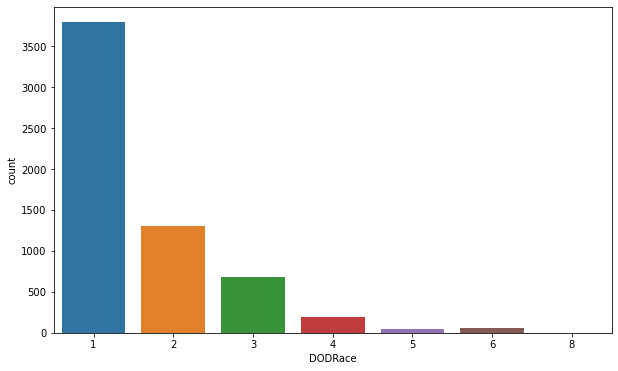

In [55]:
sns.countplot(df['DODRace'])

In [56]:
# Dropping the races that are less than 500 counts:
race_counts = df['DODRace'].value_counts()
to_keep = race_counts[race_counts > 500].index
df = df[df['DODRace'].isin(to_keep)]

In [57]:
df.shape

(5769, 106)

In [58]:
df['DODRace'].value_counts()

1    3792
2    1298
3     679
Name: DODRace, dtype: int64

In [59]:
# Changing race indices :
df["DODRace"] = df.DODRace.map({
    1: "White",
    2: "Black",
    3: "Hispanic",
})

In [60]:
# I believe race classification shoiuld based on anthropometric measurements
# Therefore I'll dropp all demographic/administrative columns



In [61]:
df.columns

Index(['abdominalextensiondepthsitting', 'acromialheight',
       'acromionradialelength', 'anklecircumference', 'axillaheight',
       'balloffootcircumference', 'balloffootlength', 'biacromialbreadth',
       'bicepscircumferenceflexed', 'bicristalbreadth',
       ...
       'Component', 'Branch', 'PrimaryMOS', 'SubjectsBirthLocation',
       'SubjectNumericRace', 'DODRace', 'Age', 'Heightin', 'Weightlbs',
       'WritingPreference'],
      dtype='object', length=106)

In [62]:
drop_list = ['SubjectsBirthLocation','SubjectNumericRace',
              'Age', 'Heightin', 'Weightlbs', 'WritingPreference',
              'Date', 'Installation', 'Component', 'Branch', 'PrimaryMOS'
             ]

In [63]:
df.drop(drop_list, axis=1, inplace = True)

In [64]:
df.shape

(5769, 95)

In [65]:
df.reset_index(drop=True, inplace=True)

In [66]:
df['Gender'].unique()

array(['Male', 'Female'], dtype=object)

In [67]:
df["Gender"] = df.Gender.map({"Male":1,"Female":0})

In [68]:
df["Gender"].unique()

array([1, 0])

In [69]:
df["Gender"]= df["Gender"].astype(int)

# DATA Preprocessing
- In this step we divide our data to X(Features) and y(Target) then ,
- To train and evaluation purposes we create train and test sets,
- Lastly, scale our data if features not in same scale. Why?

In [70]:
X = df.drop('DODRace',axis=1)
y = df['DODRace']

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, 
                                                    random_state=43, 
                                                    stratify = y)

<IPython.core.display.Javascript object>

In [72]:
print("Train features shape : ", X_train.shape)
print("Train target shape   : ", y_train.shape)
print("Test features shape  : ", X_test.shape)
print("Test target shape    : ", y_test.shape)

Train features shape :  (4038, 94)
Train target shape   :  (4038,)
Test features shape  :  (1731, 94)
Test target shape    :  (1731,)


In [73]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Modelling
- Fit the model with train dataset
- Get predict from vanilla model on both train and test sets to examine if there is over/underfitting   
- Apply GridseachCV for both hyperparemeter tuning and sanity test of our model.
- Use hyperparameters that you find from gridsearch and make final prediction and evaluate the result according to chosen metric.

In [74]:
def eval_metric(model, X_train, y_train, X_test, y_test):
    y_train_pred = model.predict(X_train)
    y_pred = model.predict(X_test)
    
    print("Test_Set_Scores","\n----------------")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    print()
    print("Train_Set_Scores","\n----------------")
    print(confusion_matrix(y_train, y_train_pred))
    print(classification_report(y_train, y_train_pred))

## 1. Logistic model

### Vanilla Logistic Model

In [75]:
log = LogisticRegression(class_weight='balanced',max_iter=10000,random_state=43)

In [76]:
log.fit(X_train,y_train)

LogisticRegression(class_weight='balanced', max_iter=10000, random_state=43)

In [77]:
eval_metric(log, X_train, y_train, X_test, y_test)

Test_Set_Scores 
----------------
[[344  36   9]
 [ 23 133  48]
 [ 24 185 929]]
              precision    recall  f1-score   support

       Black       0.88      0.88      0.88       389
    Hispanic       0.38      0.65      0.48       204
       White       0.94      0.82      0.87      1138

    accuracy                           0.81      1731
   macro avg       0.73      0.78      0.74      1731
weighted avg       0.86      0.81      0.83      1731


Train_Set_Scores 
----------------
[[ 832   50   27]
 [  38  348   89]
 [  55  480 2119]]
              precision    recall  f1-score   support

       Black       0.90      0.92      0.91       909
    Hispanic       0.40      0.73      0.51       475
       White       0.95      0.80      0.87      2654

    accuracy                           0.82      4038
   macro avg       0.75      0.82      0.76      4038
weighted avg       0.87      0.82      0.83      4038



In [78]:
# storing metrics for model comparison
y_pred = log.predict(X_test)
log_f1 = f1_score(y_test, y_pred, average='weighted')
log_recall = recall_score(y_test, y_pred, average='weighted')

### Logistic Model GridsearchCV

In [79]:
# Cross Validation

f1score= make_scorer(f1_score, average="weighted")

model = LogisticRegression(class_weight='balanced',
                           max_iter=10000,
                           random_state=43)

scores = cross_val_score(model,
                         X_train,
                         y_train,
                         cv=5,
                         scoring=f1score,
                         n_jobs=-1)

print([round(i, 4) for i in scores], "\n")
print(f" f1score : {scores.mean()}, std : %{scores.std()*100:.2f} \n")

[0.8158, 0.807, 0.8074, 0.8256, 0.8406] 

 f1score : 0.8192857034851526, std : %1.26 



In [80]:
# Optimizing Grid Search to get better 'Hispanic' scores

f1_Hispanic =  make_scorer(f1_score, average=None, labels=["Hispanic"] )

In [81]:
param_grid = {
                'class_weight': ["balanced", None],
                'penalty': ["l1", "l2"],
                'solver': ['saga', 'lbfgs'],
            }

In [82]:
model = LogisticRegression(class_weight='balanced',
                           max_iter=10000,
                           random_state=43)

log_model_grid = GridSearchCV(model,
                              param_grid,
                              verbose=3,
                              scoring=f1_Hispanic,
                              refit=True,
                              n_jobs=-1)

In [83]:
log_model_grid.fit(X_train,y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 2/5] END class_weight=balanced, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/5] END class_weight=balanced, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5] END class_weight=balanced, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5] END class_weight=balanced, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5] END class_weight=balanced, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/5] END class_weight=balanced, penalty=l2, solver=saga;, score=0.440 total time=   0.8s
[CV 2/5] END class_weight=balanced, penalty=l2, solver=saga;, score=0.452 total time=   0.9s
[CV 3/5] END class_weight=balanced, penalty=l2, solver=saga;, score=0.456 total time=   0.9s
[CV 1/5] END class_weight=balanced, penalty=l2, solver=lbfgs;, score=0.440 total time=   0.5s
[CV 4/5] END class_weight=balanced, penalty=l2, solver=saga;, score=0.515 total time=   0.8s
[CV 5/5] END c

GridSearchCV(estimator=LogisticRegression(class_weight='balanced',
                                          max_iter=10000, random_state=43),
             n_jobs=-1,
             param_grid={'class_weight': ['balanced', None],
                         'penalty': ['l1', 'l2'], 'solver': ['saga', 'lbfgs']},
             scoring=make_scorer(f1_score, average=None, labels=['Hispanic']),
             verbose=3)

In [84]:
log_model_grid.best_params_

{'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'lbfgs'}

In [85]:
eval_metric(log_model_grid, X_train, y_train, X_test, y_test)

Test_Set_Scores 
----------------
[[344  36   9]
 [ 23 133  48]
 [ 24 185 929]]
              precision    recall  f1-score   support

       Black       0.88      0.88      0.88       389
    Hispanic       0.38      0.65      0.48       204
       White       0.94      0.82      0.87      1138

    accuracy                           0.81      1731
   macro avg       0.73      0.78      0.74      1731
weighted avg       0.86      0.81      0.83      1731


Train_Set_Scores 
----------------
[[ 832   50   27]
 [  38  348   89]
 [  55  480 2119]]
              precision    recall  f1-score   support

       Black       0.90      0.92      0.91       909
    Hispanic       0.40      0.73      0.51       475
       White       0.95      0.80      0.87      2654

    accuracy                           0.82      4038
   macro avg       0.75      0.82      0.76      4038
weighted avg       0.87      0.82      0.83      4038



In [86]:
y_pred = log_model_grid.predict(X_test)
log_grid_f1 = f1_score(y_test, y_pred, average='weighted')
log_grid_recall = recall_score(y_test, y_pred, average='weighted')

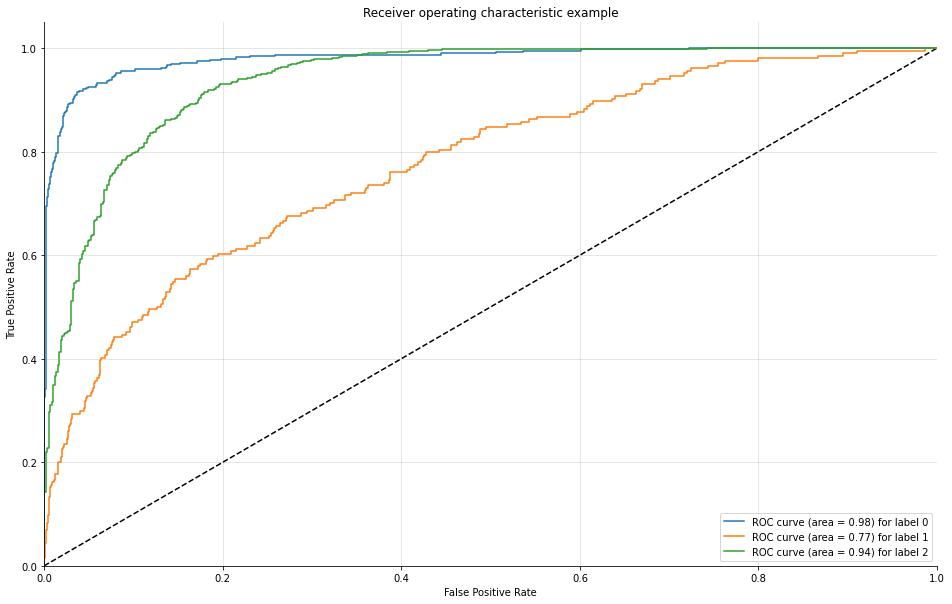

In [87]:
# ROC Curves
plot_multiclass_roc(log_model_grid,
                    X_test,
                    y_test,
                    n_classes=3,
                    figsize=(16, 10))

## KNN

In [88]:
knn = KNeighborsClassifier(n_neighbors=5)

In [89]:
knn.fit(X_train,y_train)

KNeighborsClassifier()

In [90]:
eval_metric(knn, X_train, y_train, X_test, y_test)

Test_Set_Scores 
----------------
[[ 281   15   93]
 [  21   25  158]
 [  19   33 1086]]
              precision    recall  f1-score   support

       Black       0.88      0.72      0.79       389
    Hispanic       0.34      0.12      0.18       204
       White       0.81      0.95      0.88      1138

    accuracy                           0.80      1731
   macro avg       0.68      0.60      0.62      1731
weighted avg       0.77      0.80      0.78      1731


Train_Set_Scores 
----------------
[[ 723   18  168]
 [  40  133  302]
 [  31   49 2574]]
              precision    recall  f1-score   support

       Black       0.91      0.80      0.85       909
    Hispanic       0.67      0.28      0.39       475
       White       0.85      0.97      0.90      2654

    accuracy                           0.85      4038
   macro avg       0.81      0.68      0.72      4038
weighted avg       0.84      0.85      0.83      4038



In [92]:
test_error_rates = []


for k in range(1,31):
    knn_model = KNeighborsClassifier(n_neighbors=k)
    knn_model.fit(X_train,y_train) 
   
    y_pred = knn_model.predict(X_test)
    
    test_error = 1 - accuracy_score(y_test,y_pred)
    test_error_rates.append(test_error)

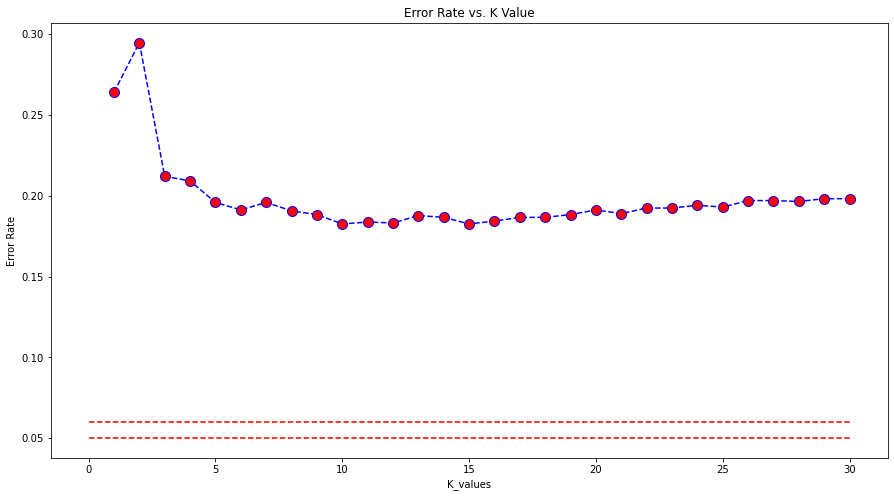

In [93]:
plt.figure(figsize=(15,8))
plt.plot(range(1,31), test_error_rates, color='blue', linestyle='--', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K_values')
plt.ylabel('Error Rate')
plt.hlines(y=0.05, xmin = 0, xmax = 30, colors= 'r', linestyles="--")
plt.hlines(y=0.06, xmin = 0, xmax = 30, colors= 'r', linestyles="--")

In [94]:
knn = KNeighborsClassifier(n_neighbors=4)
knn.fit(X_train,y_train)
eval_metric(knn, X_train, y_train, X_test, y_test)

Test_Set_Scores 
----------------
[[ 285   16   88]
 [  27   45  132]
 [  31   68 1039]]
              precision    recall  f1-score   support

       Black       0.83      0.73      0.78       389
    Hispanic       0.35      0.22      0.27       204
       White       0.83      0.91      0.87      1138

    accuracy                           0.79      1731
   macro avg       0.67      0.62      0.64      1731
weighted avg       0.77      0.79      0.78      1731


Train_Set_Scores 
----------------
[[ 773   17  119]
 [  29  229  217]
 [  50  118 2486]]
              precision    recall  f1-score   support

       Black       0.91      0.85      0.88       909
    Hispanic       0.63      0.48      0.55       475
       White       0.88      0.94      0.91      2654

    accuracy                           0.86      4038
   macro avg       0.81      0.76      0.78      4038
weighted avg       0.86      0.86      0.86      4038



In [95]:
# Grid_Search
knn_grid = KNeighborsClassifier()
k_values= range(1,31)
param_grid = {"n_neighbors":k_values, "p": [1,2], 
              "weights": ['uniform', "distance"]}

In [96]:
knn_grid_model = GridSearchCV(knn_grid, param_grid, cv=10, scoring= 'accuracy')

In [97]:
knn_grid_model.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': range(1, 31), 'p': [1, 2],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

In [98]:
knn_grid_model.best_params_

{'n_neighbors': 10, 'p': 2, 'weights': 'uniform'}

In [99]:
eval_metric(knn_grid_model, X_train, y_train, X_test, y_test)

Test_Set_Scores 
----------------
[[ 279    3  107]
 [  12   20  172]
 [  10   12 1116]]
              precision    recall  f1-score   support

       Black       0.93      0.72      0.81       389
    Hispanic       0.57      0.10      0.17       204
       White       0.80      0.98      0.88      1138

    accuracy                           0.82      1731
   macro avg       0.77      0.60      0.62      1731
weighted avg       0.80      0.82      0.78      1731


Train_Set_Scores 
----------------
[[ 671   12  226]
 [  34   92  349]
 [  20   16 2618]]
              precision    recall  f1-score   support

       Black       0.93      0.74      0.82       909
    Hispanic       0.77      0.19      0.31       475
       White       0.82      0.99      0.90      2654

    accuracy                           0.84      4038
   macro avg       0.84      0.64      0.68      4038
weighted avg       0.84      0.84      0.81      4038



In [100]:
# The best is KNN with k=4, let's keep its scores
knn = KNeighborsClassifier(n_neighbors=4)
knn.fit(X_train,y_train)
y_pred = knn.predict(X_test)
knn_f1 = f1_score(y_test, y_pred, average='weighted')
knn_recall = recall_score(y_test, y_pred, average='weighted')

## 2. SVC

### Vanilla SVC model 

In [101]:
svm = SVC(class_weight='balanced')

In [102]:
svm.fit(X_train, y_train)

SVC(class_weight='balanced')

In [103]:
eval_metric(svm, X_train, y_train, X_test, y_test)

Test_Set_Scores 
----------------
[[351  24  14]
 [ 25 119  60]
 [ 27 178 933]]
              precision    recall  f1-score   support

       Black       0.87      0.90      0.89       389
    Hispanic       0.37      0.58      0.45       204
       White       0.93      0.82      0.87      1138

    accuracy                           0.81      1731
   macro avg       0.72      0.77      0.74      1731
weighted avg       0.85      0.81      0.82      1731


Train_Set_Scores 
----------------
[[ 865   27   17]
 [  24  390   61]
 [  45  387 2222]]
              precision    recall  f1-score   support

       Black       0.93      0.95      0.94       909
    Hispanic       0.49      0.82      0.61       475
       White       0.97      0.84      0.90      2654

    accuracy                           0.86      4038
   macro avg       0.79      0.87      0.82      4038
weighted avg       0.90      0.86      0.87      4038



In [104]:
y_pred = svm.predict(X_test)
svc_f1 = f1_score(y_test, y_pred, average='weighted')
svc_recall = recall_score(y_test, y_pred, average='weighted')

###  SVC Model GridsearchCV

In [105]:
param_grid = {
    'C': np.linspace(200, 400, 5),
    'decision_function_shape': ['ovr', 'ovo'],
    'gamma': ["scale", "auto", 1, 0.1, 0.01],
    'kernel': ['rbf'],
    'class_weight': ["balanced", None]
}

In [106]:
model = SVC(class_weight="balanced")
svm_grid = GridSearchCV(model,
                              param_grid,
                              verbose=3,
                              scoring=f1_Hispanic,
                              refit=True,
                              n_jobs=-1)

In [107]:
svm_grid.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 1/5] END C=200.0, class_weight=balanced, decision_function_shape=ovr, gamma=auto, kernel=rbf;, score=0.413 total time=   2.2s
[CV 2/5] END C=200.0, class_weight=balanced, decision_function_shape=ovr, gamma=auto, kernel=rbf;, score=0.463 total time=   2.2s
[CV 3/5] END C=200.0, class_weight=balanced, decision_function_shape=ovr, gamma=auto, kernel=rbf;, score=0.458 total time=   2.3s
[CV 2/5] END C=200.0, class_weight=balanced, decision_function_shape=ovr, gamma=scale, kernel=rbf;, score=0.354 total time=   2.3s
[CV 1/5] END C=200.0, class_weight=balanced, decision_function_shape=ovr, gamma=scale, kernel=rbf;, score=0.322 total time=   2.3s
[CV 5/5] END C=200.0, class_weight=balanced, decision_function_shape=ovr, gamma=scale, kernel=rbf;, score=0.417 total time=   2.4s
[CV 4/5] END C=200.0, class_weight=balanced, decision_function_shape=ovr, gamma=scale, kernel=rbf;, score=0.446 total time=   2.4s
[CV 3/5] END C=200.0, c

[CV 5/5] END C=200.0, class_weight=None, decision_function_shape=ovr, gamma=1, kernel=rbf;, score=0.376 total time=   1.6s
[CV 1/5] END C=200.0, class_weight=None, decision_function_shape=ovr, gamma=0.01, kernel=rbf;, score=0.368 total time=   0.7s
[CV 2/5] END C=200.0, class_weight=None, decision_function_shape=ovr, gamma=0.01, kernel=rbf;, score=0.434 total time=   0.7s
[CV 3/5] END C=200.0, class_weight=None, decision_function_shape=ovr, gamma=0.01, kernel=rbf;, score=0.447 total time=   0.8s
[CV 5/5] END C=200.0, class_weight=None, decision_function_shape=ovr, gamma=0.01, kernel=rbf;, score=0.433 total time=   0.7s
[CV 4/5] END C=200.0, class_weight=None, decision_function_shape=ovr, gamma=0.01, kernel=rbf;, score=0.485 total time=   0.8s
[CV 4/5] END C=200.0, class_weight=None, decision_function_shape=ovr, gamma=0.1, kernel=rbf;, score=0.503 total time=   1.3s
[CV 5/5] END C=200.0, class_weight=None, decision_function_shape=ovr, gamma=0.1, kernel=rbf;, score=0.459 total time=   1.

[CV 4/5] END C=250.0, class_weight=balanced, decision_function_shape=ovo, gamma=auto, kernel=rbf;, score=0.515 total time=   1.4s
[CV 5/5] END C=250.0, class_weight=balanced, decision_function_shape=ovo, gamma=auto, kernel=rbf;, score=0.525 total time=   1.5s
[CV 1/5] END C=250.0, class_weight=balanced, decision_function_shape=ovo, gamma=0.1, kernel=rbf;, score=0.376 total time=   1.8s
[CV 1/5] END C=250.0, class_weight=balanced, decision_function_shape=ovo, gamma=1, kernel=rbf;, score=0.373 total time=   2.3s
[CV 2/5] END C=250.0, class_weight=balanced, decision_function_shape=ovo, gamma=1, kernel=rbf;, score=0.354 total time=   2.4s
[CV 3/5] END C=250.0, class_weight=balanced, decision_function_shape=ovo, gamma=1, kernel=rbf;, score=0.440 total time=   2.4s
[CV 5/5] END C=250.0, class_weight=balanced, decision_function_shape=ovo, gamma=1, kernel=rbf;, score=0.376 total time=   2.3s
[CV 4/5] END C=250.0, class_weight=balanced, decision_function_shape=ovo, gamma=1, kernel=rbf;, score=0

[CV 1/5] END C=300.0, class_weight=balanced, decision_function_shape=ovr, gamma=scale, kernel=rbf;, score=0.322 total time=   1.2s
[CV 2/5] END C=300.0, class_weight=balanced, decision_function_shape=ovr, gamma=scale, kernel=rbf;, score=0.354 total time=   1.2s
[CV 3/5] END C=300.0, class_weight=balanced, decision_function_shape=ovr, gamma=scale, kernel=rbf;, score=0.394 total time=   1.3s
[CV 2/5] END C=300.0, class_weight=balanced, decision_function_shape=ovr, gamma=auto, kernel=rbf;, score=0.454 total time=   1.0s
[CV 1/5] END C=300.0, class_weight=balanced, decision_function_shape=ovr, gamma=auto, kernel=rbf;, score=0.391 total time=   1.1s
[CV 4/5] END C=300.0, class_weight=balanced, decision_function_shape=ovr, gamma=scale, kernel=rbf;, score=0.446 total time=   1.2s
[CV 3/5] END C=300.0, class_weight=balanced, decision_function_shape=ovr, gamma=auto, kernel=rbf;, score=0.474 total time=   1.1s
[CV 5/5] END C=300.0, class_weight=balanced, decision_function_shape=ovr, gamma=scale,

[CV 3/5] END C=300.0, class_weight=None, decision_function_shape=ovr, gamma=1, kernel=rbf;, score=0.440 total time=   1.7s
[CV 4/5] END C=300.0, class_weight=None, decision_function_shape=ovr, gamma=1, kernel=rbf;, score=0.408 total time=   1.7s
[CV 5/5] END C=300.0, class_weight=None, decision_function_shape=ovr, gamma=1, kernel=rbf;, score=0.376 total time=   1.8s
[CV 3/5] END C=300.0, class_weight=None, decision_function_shape=ovr, gamma=0.1, kernel=rbf;, score=0.452 total time=   1.3s
[CV 1/5] END C=300.0, class_weight=None, decision_function_shape=ovr, gamma=0.01, kernel=rbf;, score=0.383 total time=   0.8s
[CV 2/5] END C=300.0, class_weight=None, decision_function_shape=ovr, gamma=0.01, kernel=rbf;, score=0.421 total time=   0.8s
[CV 3/5] END C=300.0, class_weight=None, decision_function_shape=ovr, gamma=0.01, kernel=rbf;, score=0.444 total time=   0.8s
[CV 4/5] END C=300.0, class_weight=None, decision_function_shape=ovr, gamma=0.01, kernel=rbf;, score=0.522 total time=   0.8s
[C

[CV 5/5] END C=350.0, class_weight=balanced, decision_function_shape=ovo, gamma=scale, kernel=rbf;, score=0.417 total time=   1.3s
[CV 2/5] END C=350.0, class_weight=balanced, decision_function_shape=ovo, gamma=auto, kernel=rbf;, score=0.444 total time=   1.1s
[CV 3/5] END C=350.0, class_weight=balanced, decision_function_shape=ovo, gamma=auto, kernel=rbf;, score=0.473 total time=   1.2s
[CV 4/5] END C=350.0, class_weight=balanced, decision_function_shape=ovo, gamma=auto, kernel=rbf;, score=0.527 total time=   1.2s
[CV 5/5] END C=350.0, class_weight=balanced, decision_function_shape=ovo, gamma=auto, kernel=rbf;, score=0.528 total time=   1.2s
[CV 2/5] END C=350.0, class_weight=balanced, decision_function_shape=ovo, gamma=1, kernel=rbf;, score=0.354 total time=   1.7s
[CV 1/5] END C=350.0, class_weight=balanced, decision_function_shape=ovo, gamma=0.1, kernel=rbf;, score=0.380 total time=   1.6s
[CV 1/5] END C=350.0, class_weight=balanced, decision_function_shape=ovo, gamma=1, kernel=rbf

[CV 5/5] END C=350.0, class_weight=None, decision_function_shape=ovo, gamma=0.01, kernel=rbf;, score=0.433 total time=   0.9s
[CV 4/5] END C=350.0, class_weight=None, decision_function_shape=ovo, gamma=0.1, kernel=rbf;, score=0.485 total time=   1.5s
[CV 5/5] END C=350.0, class_weight=None, decision_function_shape=ovo, gamma=0.1, kernel=rbf;, score=0.458 total time=   1.5s
[CV 1/5] END C=400.0, class_weight=balanced, decision_function_shape=ovr, gamma=scale, kernel=rbf;, score=0.322 total time=   1.3s
[CV 2/5] END C=400.0, class_weight=balanced, decision_function_shape=ovr, gamma=scale, kernel=rbf;, score=0.354 total time=   1.2s
[CV 3/5] END C=400.0, class_weight=balanced, decision_function_shape=ovr, gamma=scale, kernel=rbf;, score=0.394 total time=   1.3s
[CV 4/5] END C=400.0, class_weight=balanced, decision_function_shape=ovr, gamma=scale, kernel=rbf;, score=0.446 total time=   1.3s
[CV 5/5] END C=400.0, class_weight=balanced, decision_function_shape=ovr, gamma=scale, kernel=rbf;, 

[CV 5/5] END C=400.0, class_weight=None, decision_function_shape=ovr, gamma=1, kernel=rbf;, score=0.376 total time=   1.8s
[CV 2/5] END C=400.0, class_weight=None, decision_function_shape=ovr, gamma=0.1, kernel=rbf;, score=0.352 total time=   1.5s
[CV 3/5] END C=400.0, class_weight=None, decision_function_shape=ovr, gamma=0.1, kernel=rbf;, score=0.467 total time=   1.6s
[CV 1/5] END C=400.0, class_weight=None, decision_function_shape=ovr, gamma=0.01, kernel=rbf;, score=0.388 total time=   0.8s
[CV 2/5] END C=400.0, class_weight=None, decision_function_shape=ovr, gamma=0.01, kernel=rbf;, score=0.423 total time=   0.9s
[CV 3/5] END C=400.0, class_weight=None, decision_function_shape=ovr, gamma=0.01, kernel=rbf;, score=0.465 total time=   0.9s
[CV 4/5] END C=400.0, class_weight=None, decision_function_shape=ovr, gamma=0.01, kernel=rbf;, score=0.489 total time=   0.9s
[CV 5/5] END C=400.0, class_weight=None, decision_function_shape=ovr, gamma=0.01, kernel=rbf;, score=0.444 total time=   0.

GridSearchCV(estimator=SVC(class_weight='balanced'), n_jobs=-1,
             param_grid={'C': array([200., 250., 300., 350., 400.]),
                         'class_weight': ['balanced', None],
                         'decision_function_shape': ['ovr', 'ovo'],
                         'gamma': ['scale', 'auto', 1, 0.1, 0.01],
                         'kernel': ['rbf']},
             scoring=make_scorer(f1_score, average=None, labels=['Hispanic']),
             verbose=3)

In [108]:
svm_grid.best_params_

{'C': 250.0,
 'class_weight': 'balanced',
 'decision_function_shape': 'ovr',
 'gamma': 'auto',
 'kernel': 'rbf'}

In [109]:
eval_metric(svm_grid, X_train, y_train, X_test, y_test)

Test_Set_Scores 
----------------
[[340  41   8]
 [ 28 139  37]
 [ 26 185 927]]
              precision    recall  f1-score   support

       Black       0.86      0.87      0.87       389
    Hispanic       0.38      0.68      0.49       204
       White       0.95      0.81      0.88      1138

    accuracy                           0.81      1731
   macro avg       0.73      0.79      0.75      1731
weighted avg       0.87      0.81      0.83      1731


Train_Set_Scores 
----------------
[[ 845   42   22]
 [  24  379   72]
 [  47  443 2164]]
              precision    recall  f1-score   support

       Black       0.92      0.93      0.93       909
    Hispanic       0.44      0.80      0.57       475
       White       0.96      0.82      0.88      2654

    accuracy                           0.84      4038
   macro avg       0.77      0.85      0.79      4038
weighted avg       0.89      0.84      0.85      4038



In [110]:
y_pred = svm_grid.predict(X_test)
svc_grid_f1 = f1_score(y_test, y_pred, average='weighted')
svc_grid_recall = recall_score(y_test, y_pred, average='weighted')

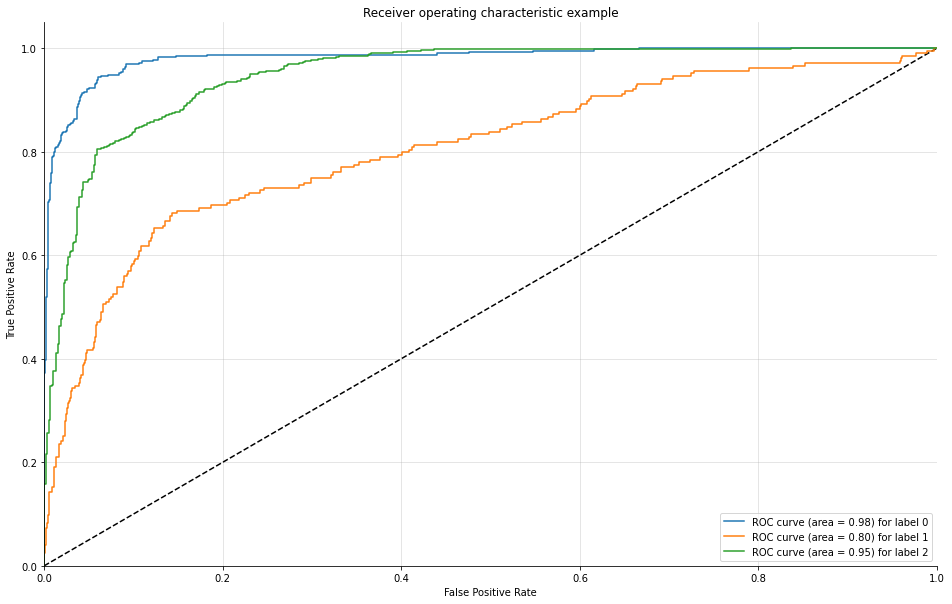

In [111]:
plot_multiclass_roc(svm_grid,
                    X_test,
                    y_test,
                    n_classes=3,
                    figsize=(16, 10))

## 3. RF

### Vanilla RF Model

In [112]:
rf = RandomForestClassifier()

In [113]:
rf.fit(X_train, y_train)

RandomForestClassifier()

In [114]:
eval_metric(rf, X_train, y_train, X_test, y_test)

Test_Set_Scores 
----------------
[[ 297    0   92]
 [  21   11  172]
 [  21    2 1115]]
              precision    recall  f1-score   support

       Black       0.88      0.76      0.82       389
    Hispanic       0.85      0.05      0.10       204
       White       0.81      0.98      0.89      1138

    accuracy                           0.82      1731
   macro avg       0.84      0.60      0.60      1731
weighted avg       0.83      0.82      0.78      1731


Train_Set_Scores 
----------------
[[ 909    0    0]
 [   0  475    0]
 [   0    0 2654]]
              precision    recall  f1-score   support

       Black       1.00      1.00      1.00       909
    Hispanic       1.00      1.00      1.00       475
       White       1.00      1.00      1.00      2654

    accuracy                           1.00      4038
   macro avg       1.00      1.00      1.00      4038
weighted avg       1.00      1.00      1.00      4038



In [115]:
y_pred = rf.predict(X_test)
rf_f1 = f1_score(y_test, y_pred, average='weighted')
rf_recall = recall_score(y_test, y_pred, average='weighted')

### RF Model GridsearchCV

In [116]:
param_grid = {'n_estimators':[400,500],
             'criterion': ["gini","entropy"],
             'max_depth':[10,12,14,16],
             'min_samples_split':[18,20,22],
             'class_weight': ['balanced',None]}

In [117]:
rf_model = RandomForestClassifier()
rf_grid = GridSearchCV(rf_model,
                        param_grid,
                        verbose=3,
                        scoring=f1_Hispanic,
                        refit=True,
                        n_jobs=-1)

In [118]:
rf_grid.fit(X_train,y_train)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
[CV 1/5] END class_weight=balanced, criterion=gini, max_depth=10, min_samples_split=18, n_estimators=400;, score=0.305 total time=   4.6s
[CV 3/5] END class_weight=balanced, criterion=gini, max_depth=10, min_samples_split=18, n_estimators=400;, score=0.327 total time=   4.6s
[CV 5/5] END class_weight=balanced, criterion=gini, max_depth=10, min_samples_split=18, n_estimators=400;, score=0.335 total time=   4.7s
[CV 4/5] END class_weight=balanced, criterion=gini, max_depth=10, min_samples_split=18, n_estimators=400;, score=0.379 total time=   4.7s
[CV 2/5] END class_weight=balanced, criterion=gini, max_depth=10, min_samples_split=18, n_estimators=400;, score=0.395 total time=   4.7s
[CV 3/5] END class_weight=balanced, criterion=gini, max_depth=10, min_samples_split=18, n_estimators=500;, score=0.322 total time=   5.8s
[CV 1/5] END class_weight=balanced, criterion=gini, max_depth=10, min_samples_split=18, n_estimators=500;, sco

[CV 4/5] END class_weight=balanced, criterion=gini, max_depth=12, min_samples_split=22, n_estimators=500;, score=0.438 total time=   6.2s
[CV 5/5] END class_weight=balanced, criterion=gini, max_depth=12, min_samples_split=22, n_estimators=500;, score=0.299 total time=   6.3s
[CV 2/5] END class_weight=balanced, criterion=gini, max_depth=14, min_samples_split=18, n_estimators=400;, score=0.351 total time=   5.2s
[CV 3/5] END class_weight=balanced, criterion=gini, max_depth=14, min_samples_split=18, n_estimators=400;, score=0.304 total time=   5.3s
[CV 4/5] END class_weight=balanced, criterion=gini, max_depth=14, min_samples_split=18, n_estimators=400;, score=0.312 total time=   5.5s
[CV 5/5] END class_weight=balanced, criterion=gini, max_depth=14, min_samples_split=18, n_estimators=400;, score=0.198 total time=   5.5s
[CV 1/5] END class_weight=balanced, criterion=gini, max_depth=14, min_samples_split=18, n_estimators=500;, score=0.263 total time=   6.8s
[CV 1/5] END class_weight=balanced

[CV 5/5] END class_weight=balanced, criterion=gini, max_depth=16, min_samples_split=22, n_estimators=500;, score=0.229 total time=   7.1s
[CV 1/5] END class_weight=balanced, criterion=entropy, max_depth=10, min_samples_split=18, n_estimators=400;, score=0.354 total time=   6.9s
[CV 2/5] END class_weight=balanced, criterion=entropy, max_depth=10, min_samples_split=18, n_estimators=400;, score=0.366 total time=   7.1s
[CV 3/5] END class_weight=balanced, criterion=entropy, max_depth=10, min_samples_split=18, n_estimators=400;, score=0.298 total time=   7.1s
[CV 4/5] END class_weight=balanced, criterion=entropy, max_depth=10, min_samples_split=18, n_estimators=400;, score=0.416 total time=   7.1s
[CV 5/5] END class_weight=balanced, criterion=entropy, max_depth=10, min_samples_split=18, n_estimators=400;, score=0.329 total time=   7.0s
[CV 1/5] END class_weight=balanced, criterion=entropy, max_depth=10, min_samples_split=18, n_estimators=500;, score=0.309 total time=   8.7s
[CV 2/5] END cla

[CV 4/5] END class_weight=balanced, criterion=entropy, max_depth=12, min_samples_split=22, n_estimators=500;, score=0.386 total time=   9.1s
[CV 1/5] END class_weight=balanced, criterion=entropy, max_depth=14, min_samples_split=18, n_estimators=400;, score=0.275 total time=   7.6s
[CV 5/5] END class_weight=balanced, criterion=entropy, max_depth=12, min_samples_split=22, n_estimators=500;, score=0.263 total time=   9.1s
[CV 2/5] END class_weight=balanced, criterion=entropy, max_depth=14, min_samples_split=18, n_estimators=400;, score=0.278 total time=   7.9s
[CV 3/5] END class_weight=balanced, criterion=entropy, max_depth=14, min_samples_split=18, n_estimators=400;, score=0.290 total time=   7.9s
[CV 4/5] END class_weight=balanced, criterion=entropy, max_depth=14, min_samples_split=18, n_estimators=400;, score=0.310 total time=   7.9s
[CV 5/5] END class_weight=balanced, criterion=entropy, max_depth=14, min_samples_split=18, n_estimators=400;, score=0.183 total time=   7.7s
[CV 2/5] END 

[CV 2/5] END class_weight=balanced, criterion=entropy, max_depth=16, min_samples_split=22, n_estimators=500;, score=0.361 total time=   9.4s
[CV 3/5] END class_weight=balanced, criterion=entropy, max_depth=16, min_samples_split=22, n_estimators=500;, score=0.262 total time=   9.5s
[CV 4/5] END class_weight=balanced, criterion=entropy, max_depth=16, min_samples_split=22, n_estimators=500;, score=0.346 total time=   9.6s
[CV 2/5] END class_weight=None, criterion=gini, max_depth=10, min_samples_split=18, n_estimators=400;, score=0.038 total time=   5.4s
[CV 3/5] END class_weight=None, criterion=gini, max_depth=10, min_samples_split=18, n_estimators=400;, score=0.061 total time=   5.4s
[CV 5/5] END class_weight=balanced, criterion=entropy, max_depth=16, min_samples_split=22, n_estimators=500;, score=0.211 total time=   9.5s
[CV 5/5] END class_weight=None, criterion=gini, max_depth=10, min_samples_split=18, n_estimators=400;, score=0.021 total time=   5.3s
[CV 4/5] END class_weight=None, cr

[CV 1/5] END class_weight=None, criterion=gini, max_depth=14, min_samples_split=18, n_estimators=400;, score=0.078 total time=   6.4s
[CV 5/5] END class_weight=None, criterion=gini, max_depth=12, min_samples_split=22, n_estimators=500;, score=0.060 total time=   7.4s
[CV 2/5] END class_weight=None, criterion=gini, max_depth=14, min_samples_split=18, n_estimators=400;, score=0.037 total time=   6.3s
[CV 3/5] END class_weight=None, criterion=gini, max_depth=14, min_samples_split=18, n_estimators=400;, score=0.079 total time=   6.4s
[CV 4/5] END class_weight=None, criterion=gini, max_depth=14, min_samples_split=18, n_estimators=400;, score=0.021 total time=   6.3s
[CV 5/5] END class_weight=None, criterion=gini, max_depth=14, min_samples_split=18, n_estimators=400;, score=0.059 total time=   6.5s
[CV 2/5] END class_weight=None, criterion=gini, max_depth=14, min_samples_split=18, n_estimators=500;, score=0.019 total time=   7.9s
[CV 1/5] END class_weight=None, criterion=gini, max_depth=14, 

[CV 2/5] END class_weight=None, criterion=entropy, max_depth=10, min_samples_split=18, n_estimators=400;, score=0.019 total time=   7.3s
[CV 3/5] END class_weight=None, criterion=entropy, max_depth=10, min_samples_split=18, n_estimators=400;, score=0.000 total time=   7.5s
[CV 4/5] END class_weight=None, criterion=entropy, max_depth=10, min_samples_split=18, n_estimators=400;, score=0.021 total time=   7.6s
[CV 5/5] END class_weight=None, criterion=entropy, max_depth=10, min_samples_split=18, n_estimators=400;, score=0.041 total time=   7.5s
[CV 1/5] END class_weight=None, criterion=entropy, max_depth=10, min_samples_split=18, n_estimators=500;, score=0.041 total time=   9.5s
[CV 2/5] END class_weight=None, criterion=entropy, max_depth=10, min_samples_split=18, n_estimators=500;, score=0.039 total time=   9.6s
[CV 3/5] END class_weight=None, criterion=entropy, max_depth=10, min_samples_split=18, n_estimators=500;, score=0.061 total time=   9.4s
[CV 1/5] END class_weight=None, criterion

[CV 2/5] END class_weight=None, criterion=entropy, max_depth=14, min_samples_split=18, n_estimators=400;, score=0.039 total time=   7.9s
[CV 3/5] END class_weight=None, criterion=entropy, max_depth=14, min_samples_split=18, n_estimators=400;, score=0.081 total time=   8.1s
[CV 5/5] END class_weight=None, criterion=entropy, max_depth=14, min_samples_split=18, n_estimators=400;, score=0.041 total time=   8.1s
[CV 4/5] END class_weight=None, criterion=entropy, max_depth=14, min_samples_split=18, n_estimators=400;, score=0.021 total time=   8.2s
[CV 1/5] END class_weight=None, criterion=entropy, max_depth=14, min_samples_split=18, n_estimators=500;, score=0.041 total time=   9.8s
[CV 2/5] END class_weight=None, criterion=entropy, max_depth=14, min_samples_split=18, n_estimators=500;, score=0.038 total time=  10.0s
[CV 3/5] END class_weight=None, criterion=entropy, max_depth=14, min_samples_split=18, n_estimators=500;, score=0.041 total time=   9.9s
[CV 4/5] END class_weight=None, criterion

GridSearchCV(estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'class_weight': ['balanced', None],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [10, 12, 14, 16],
                         'min_samples_split': [18, 20, 22],
                         'n_estimators': [400, 500]},
             scoring=make_scorer(f1_score, average=None, labels=['Hispanic']),
             verbose=3)

In [119]:
rf_grid.best_params_

{'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': 10,
 'min_samples_split': 20,
 'n_estimators': 500}

In [120]:
eval_metric(rf_grid, X_train, y_train, X_test, y_test)

Test_Set_Scores 
----------------
[[ 319   12   58]
 [  25   68  111]
 [  44   77 1017]]
              precision    recall  f1-score   support

       Black       0.82      0.82      0.82       389
    Hispanic       0.43      0.33      0.38       204
       White       0.86      0.89      0.88      1138

    accuracy                           0.81      1731
   macro avg       0.70      0.68      0.69      1731
weighted avg       0.80      0.81      0.80      1731


Train_Set_Scores 
----------------
[[ 875    4   30]
 [   5  446   24]
 [  43   98 2513]]
              precision    recall  f1-score   support

       Black       0.95      0.96      0.96       909
    Hispanic       0.81      0.94      0.87       475
       White       0.98      0.95      0.96      2654

    accuracy                           0.95      4038
   macro avg       0.91      0.95      0.93      4038
weighted avg       0.95      0.95      0.95      4038



In [121]:
y_pred = rf_grid.predict(X_test)
rf_grid_f1 = f1_score(y_test, y_pred, average='weighted')
rf_grid_recall = recall_score(y_test, y_pred, average='weighted')

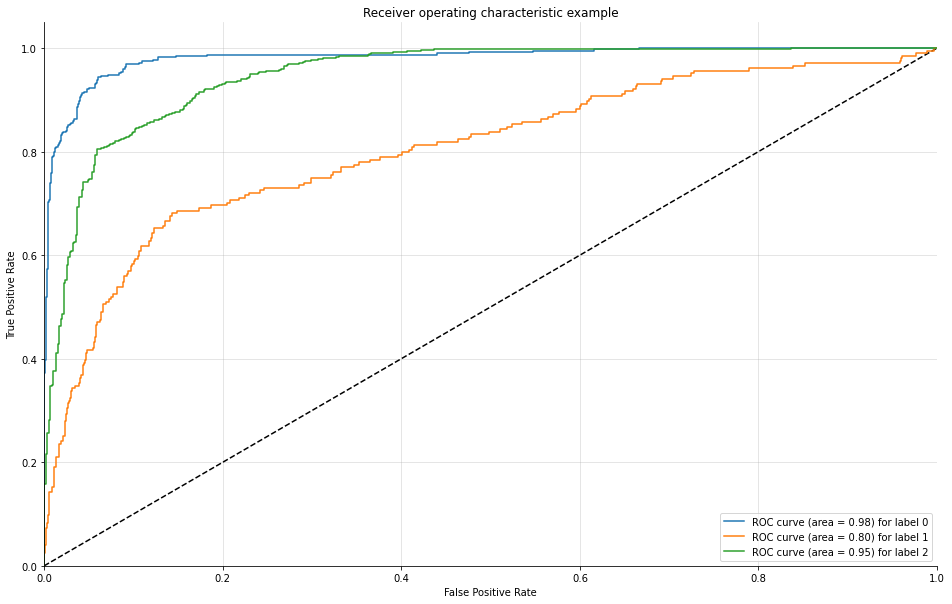

In [122]:
plot_multiclass_roc(svm_grid,
                    X_test,
                    y_test,
                    n_classes=3,
                    figsize=(16, 10))

In [125]:
rf_feature_imp = pd.DataFrame(index = X.columns, data = rf.feature_importances_,
                              columns = ["Feature Importance"]).sort_values("Feature Importance", ascending = False)
rf_feature_imp

,Feature Importance
sittingheight,0.045
eyeheightsitting,0.041
interpupillarybreadth,0.039
heelbreadth,0.037
elbowrestheight,0.033
...,...
poplitealheight,0.006
shoulderlength,0.006
bimalleolarbreadth,0.006
earbreadth,0.005


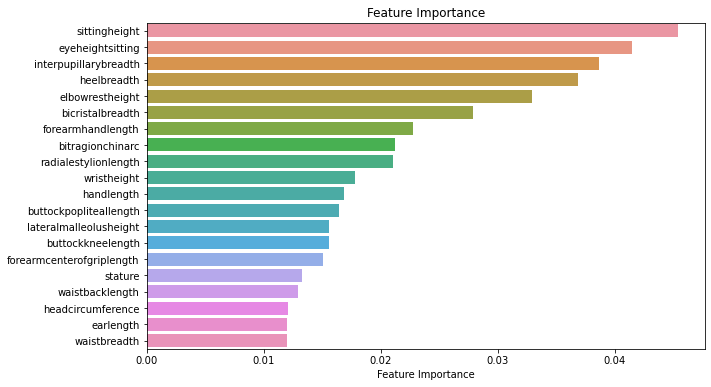

In [130]:
# 20 Most important features
sns.barplot(x=rf_feature_imp["Feature Importance"].head(20), y=rf_feature_imp.index[:20])
plt.title("Feature Importance")
plt.show()

## 4. XGBoost

In [131]:
from xgboost import XGBClassifier

### Vanilla XGBoost Model

In [132]:
xgb = XGBClassifier()

In [134]:
from sklearn.utils import class_weight
classes_weights = class_weight.compute_sample_weight(class_weight='balanced', y=y_train)
classes_weights

array([0.50715901, 2.83368421, 1.48074807, ..., 0.50715901, 0.50715901,
       1.48074807])

In [135]:
xgb.fit(X_train,y_train,sample_weight=classes_weights)

[23:42:13] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [137]:
eval_metric(xgb, X_train, y_train, X_test, y_test)

Test_Set_Scores 
----------------
[[ 340    8   41]
 [  19   59  126]
 [  25   33 1080]]
              precision    recall  f1-score   support

       Black       0.89      0.87      0.88       389
    Hispanic       0.59      0.29      0.39       204
       White       0.87      0.95      0.91      1138

    accuracy                           0.85      1731
   macro avg       0.78      0.70      0.72      1731
weighted avg       0.84      0.85      0.84      1731


Train_Set_Scores 
----------------
[[ 909    0    0]
 [   0  475    0]
 [   0    0 2654]]
              precision    recall  f1-score   support

       Black       1.00      1.00      1.00       909
    Hispanic       1.00      1.00      1.00       475
       White       1.00      1.00      1.00      2654

    accuracy                           1.00      4038
   macro avg       1.00      1.00      1.00      4038
weighted avg       1.00      1.00      1.00      4038



In [138]:
y_pred = xgb.predict(X_test)
xgb_f1 = f1_score(y_test, y_pred, average='weighted')
xgb_recall = recall_score(y_test, y_pred, average='weighted')

### XGBoost Model GridsearchCV

In [139]:
param_grid = {"n_estimators":[100, 300],
              'max_depth':[3,5,6],
              "learning_rate": [0.1, 0.3],
              "subsample":[0.5, 1],
              "colsample_bytree":[0.5, 1]}

In [140]:
xgb_model = XGBClassifier()
xgb_grid_model = GridSearchCV(xgb_model, 
                              param_grid, 
                              scoring=f1_Hispanic, 
                              n_jobs = -1,refit=True, 
                              verbose = 2).fit(X_train, y_train,sample_weight=classes_weights)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/hakantekin/opt/anaconda3/lib/python3.9/site-package

[23:47:48] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:47:48] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:47:48] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:47:48] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the ol

/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/hakantekin/opt/anaconda3/lib/python3.9/site-package

[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.5; total time=   8.5s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.5; total time=   8.5s
[23:47:56] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:47:56] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:47:56] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:47:56] 

/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=1; total time=   8.1s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=1; total time=   8.1s
[23:48:04] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:48:04] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=3, n_estimators=300, subsample=0.5; total time=  24.3s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=3, n_estimators=300, subsample=0.5; total time=  24.3s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=3, n_estimators=300, subsample=0.5; total time=  24.3s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=3, n_estimators=300, subsample=0.5; total time=  24.4s
[23:48:20] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:48:20] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.5, lea

/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/hakantekin/opt/anaconda3/lib/python3.9/site-package

[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=3, n_estimators=300, subsample=1; total time=  24.5s
[23:48:20] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:48:20] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:48:21] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:48:21] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=3, n_estimators=300, subsample=1; total time=  23.8s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=3, n_estimators=300, subsample=1; total time=  23.8s


/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:48:28] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:48:28] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.5; total time=  15.9s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.5; total time=  15.9s
[23:48:36] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:48:36] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.5; total time=  16.0s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.5; total time=  15.9s


/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:48:37] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:48:37] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=3, n_estimators=300, subsample=1; total time=  22.2s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=3, n_estimators=300, subsample=1; total time=  22.3s


/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:48:43] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:48:43] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.5; total time=  15.8s


/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:48:44] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=1; total time=  16.4s


/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:48:44] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=1; total time=  15.8s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=1; total time=  16.1s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=1; total time=  16.2s


/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/hakantekin/opt/anaconda3/lib/python3.9/site-package

[23:48:52] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:48:52] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:48:52] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=1; total time=  16.2s


/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:48:53] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=5, n_estimators=300, subsample=0.5; total time=  42.7s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=5, n_estimators=300, subsample=0.5; total time=  42.8s


/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:49:25] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:49:25] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=5, n_estimators=300, subsample=0.5; total time=  43.1s


/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:49:27] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=5, n_estimators=300, subsample=0.5; total time=  42.9s


/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:49:27] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=5, n_estimators=300, subsample=0.5; total time=  42.8s


/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:49:35] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=5, n_estimators=300, subsample=1; total time=  44.2s


/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=5, n_estimators=300, subsample=1; total time=  44.5s
[23:49:37] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:49:37] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=5, n_estimators=300, subsample=1; total time=  44.8s


/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:49:38] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=6, n_estimators=100, subsample=0.5; total time=  19.6s


/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:49:46] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=6, n_estimators=100, subsample=0.5; total time=  19.6s


/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:49:47] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=6, n_estimators=100, subsample=0.5; total time=  19.5s


/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:49:55] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=6, n_estimators=100, subsample=0.5; total time=  19.5s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=6, n_estimators=100, subsample=0.5; total time=  19.4s


/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:49:56] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:49:56] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=6, n_estimators=100, subsample=1; total time=  21.3s


/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:49:59] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=5, n_estimators=300, subsample=1; total time=  42.5s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=6, n_estimators=100, subsample=1; total time=  21.4s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=5, n_estimators=300, subsample=1; total time=  42.4s


/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/hakantekin/opt/anaconda3/lib/python3.9/site-package

[23:50:08] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:50:08] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:50:08] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=6, n_estimators=100, subsample=1; total time=  21.8s


/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:50:09] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=6, n_estimators=100, subsample=1; total time=  21.0s


/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:50:16] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=6, n_estimators=100, subsample=1; total time=  21.2s


/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:50:17] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=6, n_estimators=300, subsample=0.5; total time=  50.0s


/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:50:46] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=6, n_estimators=300, subsample=0.5; total time=  50.5s


/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:50:49] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=6, n_estimators=300, subsample=0.5; total time=  51.1s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=6, n_estimators=300, subsample=0.5; total time=  51.2s
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=6, n_estimators=300, subsample=0.5; total time=  51.3s
[23:50:59] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:50:59] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was cha

/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/hakantekin/opt/anaconda3/lib/python3.9/site-package

[23:50:59] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=6, n_estimators=300, subsample=1; total time=  54.7s
[23:51:03] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=3, n_estimators=100, subsample=0.5; total time=   7.7s
[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=3, n_estimators=100, subsample=0.5; total time=   7.6s
[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=3, n_estimators=100, subsample=0.5; total time=   7.6s
[23:51:07] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:51:07] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:51:07] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was cha

/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/hakantekin/opt/anaconda3/lib/python3.9/site-package

[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=3, n_estimators=100, subsample=0.5; total time=   7.7s
[23:51:11] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=6, n_estimators=300, subsample=1; total time=  55.4s
[23:51:11] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=6, n_estimators=300, subsample=1; total time=  56.7s
[23:51:14] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=3, n_estimators=100, subsample=1; total time=   7.8s
[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=3, n_estimators=100, subsample=1; total time=   7.8s
[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=3, n_estimators=100, subsample=0.5; total time=   7.9s
[23:51:14] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:51:14] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:51:14] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed

/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/hakantekin/opt/anaconda3/lib/python3.9/site-package

[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=3, n_estimators=100, subsample=1; total time=   7.9s
[23:51:19] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=3, n_estimators=100, subsample=1; total time=   7.9s


/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:51:19] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=3, n_estimators=100, subsample=1; total time=   7.9s
[23:51:22] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=3, n_estimators=300, subsample=0.5; total time=  23.2s
[23:51:38] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=3, n_estimators=300, subsample=0.5; total time=  23.3s
[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=3, n_estimators=300, subsample=0.5; total time=  23.3s


/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/hakantekin/opt/anaconda3/lib/python3.9/site-package

[23:51:38] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:51:38] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=3, n_estimators=300, subsample=0.5; total time=  23.3s
[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=3, n_estimators=300, subsample=0.5; total time=  23.5s
[23:51:42] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:51:42] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=3, n_estimators=300, subsample=1; total time=  23.4s


/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:51:45] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=6, n_estimators=300, subsample=1; total time= 1.0min


/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:51:47] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.5, learning_rate=0.1, max_depth=6, n_estimators=300, subsample=1; total time= 1.0min


/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:51:50] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=5, n_estimators=100, subsample=0.5; total time=  15.5s


/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:51:58] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=5, n_estimators=100, subsample=0.5; total time=  15.5s
[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=3, n_estimators=300, subsample=1; total time=  23.2s
[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=3, n_estimators=300, subsample=1; total time=  23.2s


/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/hakantekin/opt/anaconda3/lib/python3.9/site-package

[23:52:01] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=3, n_estimators=300, subsample=1; total time=  23.3s
[23:52:01] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:52:01] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:52:01] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=5, n_estimators=100, subsample=0.5; total time=  15.6s
[23:52:03] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=3, n_estimators=300, subsample=1; total time=  22.8s
[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=5, n_estimators=100, subsample=0.5; total time=  15.4s


/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:52:05] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:52:05] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=5, n_estimators=100, subsample=0.5; total time=  14.7s


/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:52:13] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=5, n_estimators=100, subsample=1; total time=  15.1s
[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=5, n_estimators=100, subsample=1; total time=  15.1s
[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=5, n_estimators=100, subsample=1; total time=  15.3s
[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=5, n_estimators=100, subsample=1; total time=  15.1s


/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/hakantekin/opt/anaconda3/lib/python3.9/site-package

[23:52:16] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:52:16] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:52:16] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:52:16] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the ol

/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:52:18] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=5, n_estimators=300, subsample=0.5; total time=  36.0s
[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=5, n_estimators=300, subsample=0.5; total time=  36.0s


/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:52:41] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:52:41] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=5, n_estimators=300, subsample=0.5; total time=  37.0s


/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:52:50] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=5, n_estimators=300, subsample=0.5; total time=  37.2s
[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=5, n_estimators=300, subsample=0.5; total time=  37.2s


/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:52:53] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:52:53] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=5, n_estimators=300, subsample=1; total time=  38.3s
[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=5, n_estimators=300, subsample=1; total time=  38.4s


/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:52:55] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:52:55] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=5, n_estimators=300, subsample=1; total time=  38.6s


/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:52:57] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=6, n_estimators=100, subsample=0.5; total time=  18.0s


/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:53:08] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=6, n_estimators=100, subsample=0.5; total time=  18.0s
[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=6, n_estimators=100, subsample=0.5; total time=  18.0s


/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:53:11] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:53:11] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=6, n_estimators=100, subsample=0.5; total time=  18.0s
[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=6, n_estimators=100, subsample=0.5; total time=  18.0s


/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:53:13] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:53:13] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=6, n_estimators=100, subsample=1; total time=  19.1s


/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:53:16] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=5, n_estimators=300, subsample=1; total time=  37.3s


/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:53:19] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=5, n_estimators=300, subsample=1; total time=  37.6s


/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:53:19] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=6, n_estimators=100, subsample=1; total time=  19.1s


/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:53:27] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=6, n_estimators=100, subsample=1; total time=  18.9s


/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=6, n_estimators=100, subsample=1; total time=  19.2s
[23:53:30] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:53:31] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=6, n_estimators=100, subsample=1; total time=  18.9s


/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:53:31] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=6, n_estimators=300, subsample=0.5; total time=  38.8s


/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:53:52] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=6, n_estimators=300, subsample=0.5; total time=  39.2s


/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:53:55] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=6, n_estimators=300, subsample=0.5; total time=  40.1s
[23:53:59] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=6, n_estimators=300, subsample=0.5; total time=  39.9s
[23:53:59] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END colsample_bytree=1, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.5; total time=   8.8s
[23:54:07] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END colsample_bytree=1, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.5; total time=   8.8s
[23:54:08] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=6, n_estimators=300, subsample=0.5; total time=  41.8s
[23:54:09] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=6, n_estimators=300, subsample=1; total time=  44.7s
[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=6, n_estimators=300, subsample=1; total time=  45.0s
[23:54:15] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:54:15] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END colsample_bytree=1, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.5; total time=   9.6s
[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=6, n_estimators=300, subsample=1; total time=  45.8s
[23:54:17] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:54:17] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=1, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.5; total time=   9.7s


/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:54:17] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=1, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.5; total time=  10.1s
[23:54:19] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END colsample_bytree=1, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=1; total time=  11.1s
[23:54:26] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=1, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=1; total time=  11.3s


/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:54:26] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=1, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=1; total time=  11.2s
[23:54:28] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=1, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=1; total time=  11.3s


/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:54:28] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=1, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=1; total time=  11.2s
[23:54:29] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=6, n_estimators=300, subsample=1; total time=  55.7s
[23:54:47] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END colsample_bytree=1, learning_rate=0.1, max_depth=3, n_estimators=300, subsample=0.5; total time=  33.6s
[23:54:52] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=0.5, learning_rate=0.3, max_depth=6, n_estimators=300, subsample=1; total time=  57.5s


/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:54:53] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=1, learning_rate=0.1, max_depth=3, n_estimators=300, subsample=0.5; total time=  34.0s
[23:55:00] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END colsample_bytree=1, learning_rate=0.1, max_depth=3, n_estimators=300, subsample=0.5; total time=  34.2s


/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:55:01] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=1, learning_rate=0.1, max_depth=3, n_estimators=300, subsample=0.5; total time=  33.8s


/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:55:02] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=1, learning_rate=0.1, max_depth=3, n_estimators=300, subsample=0.5; total time=  34.3s
[CV] END colsample_bytree=1, learning_rate=0.1, max_depth=3, n_estimators=300, subsample=1; total time=  34.2s


/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:55:03] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:55:03] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=1, learning_rate=0.1, max_depth=3, n_estimators=300, subsample=1; total time=  33.8s


/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:55:21] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=1, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.5; total time=  23.6s


/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:55:24] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=1, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.5; total time=  23.7s
[CV] END colsample_bytree=1, learning_rate=0.1, max_depth=3, n_estimators=300, subsample=1; total time=  33.5s


/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END colsample_bytree=1, learning_rate=0.1, max_depth=3, n_estimators=300, subsample=1; total time=  33.6s
[23:55:26] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:55:26] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=1, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.5; total time=  23.6s


/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END colsample_bytree=1, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.5; total time=  23.6s
[23:55:26] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:55:27] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:55:27] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=1, learning_rate=0.1, max_depth=3, n_estimators=300, subsample=1; total time=  32.4s


/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:55:33] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=1, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.5; total time=  23.4s


/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:55:44] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=1, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=1; total time=  23.9s


/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:55:48] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=1, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=1; total time=  23.7s
[CV] END colsample_bytree=1, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=1; total time=  23.8s


/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:55:50] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:55:50] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=1, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=1; total time=  23.9s


/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END colsample_bytree=1, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=1; total time=  23.8s
[23:55:50] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:55:50] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=1, learning_rate=0.1, max_depth=5, n_estimators=300, subsample=0.5; total time= 1.0min


/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:56:29] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=1, learning_rate=0.1, max_depth=5, n_estimators=300, subsample=0.5; total time= 1.1min


/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:56:36] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=1, learning_rate=0.1, max_depth=5, n_estimators=300, subsample=0.5; total time= 1.0min


/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:56:47] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=1, learning_rate=0.1, max_depth=5, n_estimators=300, subsample=0.5; total time= 1.0min


/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:56:51] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=1, learning_rate=0.1, max_depth=5, n_estimators=300, subsample=0.5; total time= 1.0min


/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:56:53] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=1, learning_rate=0.1, max_depth=5, n_estimators=300, subsample=1; total time= 1.1min


/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:56:55] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=1, learning_rate=0.1, max_depth=5, n_estimators=300, subsample=1; total time= 1.1min
[CV] END colsample_bytree=1, learning_rate=0.1, max_depth=5, n_estimators=300, subsample=1; total time= 1.1min


/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:56:56] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:56:56] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=1, learning_rate=0.1, max_depth=6, n_estimators=100, subsample=0.5; total time=  28.1s


/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:57:15] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=1, learning_rate=0.1, max_depth=6, n_estimators=100, subsample=0.5; total time=  28.3s


/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:57:19] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=1, learning_rate=0.1, max_depth=6, n_estimators=100, subsample=0.5; total time=  28.1s


/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:57:21] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=1, learning_rate=0.1, max_depth=6, n_estimators=100, subsample=0.5; total time=  28.0s


/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:57:23] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=1, learning_rate=0.1, max_depth=6, n_estimators=100, subsample=0.5; total time=  28.1s


/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:57:24] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=1, learning_rate=0.1, max_depth=6, n_estimators=100, subsample=1; total time=  31.3s


/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:57:27] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=1, learning_rate=0.1, max_depth=5, n_estimators=300, subsample=1; total time= 1.1min


/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:57:32] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=1, learning_rate=0.1, max_depth=5, n_estimators=300, subsample=1; total time= 1.0min


/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:57:38] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=1, learning_rate=0.1, max_depth=6, n_estimators=100, subsample=1; total time=  30.8s


/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:57:46] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=1, learning_rate=0.1, max_depth=6, n_estimators=100, subsample=1; total time=  30.3s


/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:57:50] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=1, learning_rate=0.1, max_depth=6, n_estimators=100, subsample=1; total time=  30.3s


/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:57:51] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=1, learning_rate=0.1, max_depth=6, n_estimators=100, subsample=1; total time=  29.8s


/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:57:53] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=1, learning_rate=0.1, max_depth=6, n_estimators=300, subsample=0.5; total time= 1.2min


/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:58:37] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=1, learning_rate=0.1, max_depth=6, n_estimators=300, subsample=0.5; total time= 1.2min


/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:58:41] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=1, learning_rate=0.1, max_depth=6, n_estimators=300, subsample=0.5; total time= 1.2min
[23:58:46] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END colsample_bytree=1, learning_rate=0.1, max_depth=6, n_estimators=300, subsample=0.5; total time= 1.2min
[23:58:52] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END colsample_bytree=1, learning_rate=0.3, max_depth=3, n_estimators=100, subsample=0.5; total time=  11.0s
[23:58:57] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END colsample_bytree=1, learning_rate=0.1, max_depth=6, n_estimators=300, subsample=0.5; total time= 1.3min
[23:59:01] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END colsample_bytree=1, learning_rate=0.3, max_depth=3, n_estimators=100, subsample=0.5; total time=  11.2s
[23:59:03] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END colsample_bytree=1, learning_rate=0.3, max_depth=3, n_estimators=100, subsample=0.5; total time=  11.5s
[23:59:09] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END colsample_bytree=1, learning_rate=0.1, max_depth=6, n_estimators=300, subsample=1; total time= 1.4min
[23:59:12] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END colsample_bytree=1, learning_rate=0.3, max_depth=3, n_estimators=100, subsample=0.5; total time=  11.5s
[23:59:13] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END colsample_bytree=1, learning_rate=0.1, max_depth=6, n_estimators=300, subsample=1; total time= 1.4min
[23:59:14] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END colsample_bytree=1, learning_rate=0.3, max_depth=3, n_estimators=100, subsample=0.5; total time=  11.5s
[23:59:14] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END colsample_bytree=1, learning_rate=0.1, max_depth=6, n_estimators=300, subsample=1; total time= 1.4min
[23:59:16] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END colsample_bytree=1, learning_rate=0.3, max_depth=3, n_estimators=100, subsample=1; total time=  11.7s
[23:59:21] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END colsample_bytree=1, learning_rate=0.3, max_depth=3, n_estimators=100, subsample=1; total time=  11.8s
[23:59:24] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END colsample_bytree=1, learning_rate=0.3, max_depth=3, n_estimators=100, subsample=1; total time=  11.8s
[23:59:25] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END colsample_bytree=1, learning_rate=0.3, max_depth=3, n_estimators=100, subsample=1; total time=  11.9s
[23:59:25] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END colsample_bytree=1, learning_rate=0.3, max_depth=3, n_estimators=100, subsample=1; total time=  11.8s
[23:59:26] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END colsample_bytree=1, learning_rate=0.3, max_depth=3, n_estimators=300, subsample=0.5; total time=  35.2s
[23:59:51] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END colsample_bytree=1, learning_rate=0.3, max_depth=3, n_estimators=300, subsample=0.5; total time=  35.1s
[23:59:56] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END colsample_bytree=1, learning_rate=0.3, max_depth=3, n_estimators=300, subsample=0.5; total time=  35.2s
[23:59:59] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV] END colsample_bytree=1, learning_rate=0.3, max_depth=3, n_estimators=300, subsample=0.5; total time=  35.4s


/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:00:00] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=1, learning_rate=0.3, max_depth=3, n_estimators=300, subsample=0.5; total time=  35.8s


/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:00:02] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=1, learning_rate=0.3, max_depth=3, n_estimators=300, subsample=1; total time=  36.4s


/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:00:03] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=1, learning_rate=0.1, max_depth=6, n_estimators=300, subsample=1; total time= 1.5min


/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:00:08] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=1, learning_rate=0.1, max_depth=6, n_estimators=300, subsample=1; total time= 1.5min


/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:00:12] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=1, learning_rate=0.3, max_depth=5, n_estimators=100, subsample=0.5; total time=  24.3s


/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:00:26] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=1, learning_rate=0.3, max_depth=5, n_estimators=100, subsample=0.5; total time=  23.9s


/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:00:27] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=1, learning_rate=0.3, max_depth=3, n_estimators=300, subsample=1; total time=  36.5s


/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:00:28] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=1, learning_rate=0.3, max_depth=5, n_estimators=100, subsample=0.5; total time=  23.8s


/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:00:32] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=1, learning_rate=0.3, max_depth=3, n_estimators=300, subsample=1; total time=  36.4s


/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:00:33] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=1, learning_rate=0.3, max_depth=5, n_estimators=100, subsample=0.5; total time=  23.5s


/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:00:35] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=1, learning_rate=0.3, max_depth=3, n_estimators=300, subsample=1; total time=  36.3s


/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:00:35] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=1, learning_rate=0.3, max_depth=3, n_estimators=300, subsample=1; total time=  35.7s


/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:00:36] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=1, learning_rate=0.3, max_depth=5, n_estimators=100, subsample=0.5; total time=  22.1s


/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:00:48] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=1, learning_rate=0.3, max_depth=5, n_estimators=100, subsample=1; total time=  23.1s


/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:00:50] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=1, learning_rate=0.3, max_depth=5, n_estimators=100, subsample=1; total time=  23.1s


/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:00:51] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=1, learning_rate=0.3, max_depth=5, n_estimators=100, subsample=1; total time=  22.9s


/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:00:55] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=1, learning_rate=0.3, max_depth=5, n_estimators=100, subsample=1; total time=  22.7s


/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:00:55] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=1, learning_rate=0.3, max_depth=5, n_estimators=100, subsample=1; total time=  22.3s


/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:00:57] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=1, learning_rate=0.3, max_depth=5, n_estimators=300, subsample=0.5; total time=  52.7s


/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:01:28] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=1, learning_rate=0.3, max_depth=5, n_estimators=300, subsample=0.5; total time=  52.9s


/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:01:29] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=1, learning_rate=0.3, max_depth=5, n_estimators=300, subsample=0.5; total time=  54.9s


/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:01:43] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=1, learning_rate=0.3, max_depth=5, n_estimators=300, subsample=0.5; total time=  54.9s


/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:01:45] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=1, learning_rate=0.3, max_depth=5, n_estimators=300, subsample=0.5; total time=  55.0s


/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:01:46] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=1, learning_rate=0.3, max_depth=5, n_estimators=300, subsample=1; total time=  57.0s


/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:01:52] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=1, learning_rate=0.3, max_depth=5, n_estimators=300, subsample=1; total time=  57.1s


/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:01:52] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=1, learning_rate=0.3, max_depth=5, n_estimators=300, subsample=1; total time=  57.2s


/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:01:55] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=1, learning_rate=0.3, max_depth=6, n_estimators=100, subsample=0.5; total time=  27.1s


/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:02:10] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=1, learning_rate=0.3, max_depth=6, n_estimators=100, subsample=0.5; total time=  27.0s


/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:02:12] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=1, learning_rate=0.3, max_depth=6, n_estimators=100, subsample=0.5; total time=  27.0s


/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:02:13] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=1, learning_rate=0.3, max_depth=6, n_estimators=100, subsample=0.5; total time=  27.0s


/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:02:19] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=1, learning_rate=0.3, max_depth=6, n_estimators=100, subsample=0.5; total time=  26.8s


/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:02:19] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=1, learning_rate=0.3, max_depth=6, n_estimators=100, subsample=1; total time=  28.9s


/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:02:24] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=1, learning_rate=0.3, max_depth=5, n_estimators=300, subsample=1; total time=  56.4s
[CV] END colsample_bytree=1, learning_rate=0.3, max_depth=5, n_estimators=300, subsample=1; total time=  56.0s


/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:02:25] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:02:25] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=1, learning_rate=0.3, max_depth=6, n_estimators=100, subsample=1; total time=  28.0s


/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:02:38] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=1, learning_rate=0.3, max_depth=6, n_estimators=100, subsample=1; total time=  28.6s


/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:02:41] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=1, learning_rate=0.3, max_depth=6, n_estimators=100, subsample=1; total time=  28.3s


/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:02:42] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=1, learning_rate=0.3, max_depth=6, n_estimators=100, subsample=1; total time=  28.0s


/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:02:47] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=1, learning_rate=0.3, max_depth=6, n_estimators=300, subsample=0.5; total time=  57.6s


/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:03:17] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=1, learning_rate=0.3, max_depth=6, n_estimators=300, subsample=0.5; total time=  58.0s


/Users/hakantekin/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:03:22] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END colsample_bytree=1, learning_rate=0.3, max_depth=6, n_estimators=300, subsample=0.5; total time=  58.3s
[CV] END colsample_bytree=1, learning_rate=0.3, max_depth=6, n_estimators=300, subsample=0.5; total time=  58.4s
[CV] END colsample_bytree=1, learning_rate=0.3, max_depth=6, n_estimators=300, subsample=0.5; total time=  56.5s
[CV] END colsample_bytree=1, learning_rate=0.3, max_depth=6, n_estimators=300, subsample=1; total time=  57.7s
[CV] END colsample_bytree=1, learning_rate=0.3, max_depth=6, n_estimators=300, subsample=1; total time=  57.0s
[CV] END colsample_bytree=1, learning_rate=0.3, max_depth=6, n_estimators=300, subsample=1; total time=  54.3s
[CV] END colsample_bytree=1, learning_rate=0.3, max_depth=6, n_estimators=3

In [141]:
xgb_grid_model.best_params_

{'colsample_bytree': 0.5,
 'learning_rate': 0.1,
 'max_depth': 3,
 'n_estimators': 300,
 'subsample': 0.5}

In [142]:
eval_metric(xgb_grid_model, X_train, y_train, X_test, y_test)

Test_Set_Scores 
----------------
[[344  17  28]
 [ 21  97  86]
 [ 31 113 994]]
              precision    recall  f1-score   support

       Black       0.87      0.88      0.88       389
    Hispanic       0.43      0.48      0.45       204
       White       0.90      0.87      0.89      1138

    accuracy                           0.83      1731
   macro avg       0.73      0.74      0.74      1731
weighted avg       0.84      0.83      0.83      1731


Train_Set_Scores 
----------------
[[ 898    3    8]
 [   0  468    7]
 [  27  107 2520]]
              precision    recall  f1-score   support

       Black       0.97      0.99      0.98       909
    Hispanic       0.81      0.99      0.89       475
       White       0.99      0.95      0.97      2654

    accuracy                           0.96      4038
   macro avg       0.92      0.97      0.95      4038
weighted avg       0.97      0.96      0.96      4038



In [144]:
y_pred = xgb_grid_model.predict(X_test)
xgb_grid_f1 = f1_score(y_test, y_pred, average='weighted')
xgb_grid_recall = recall_score(y_test, y_pred, average='weighted')

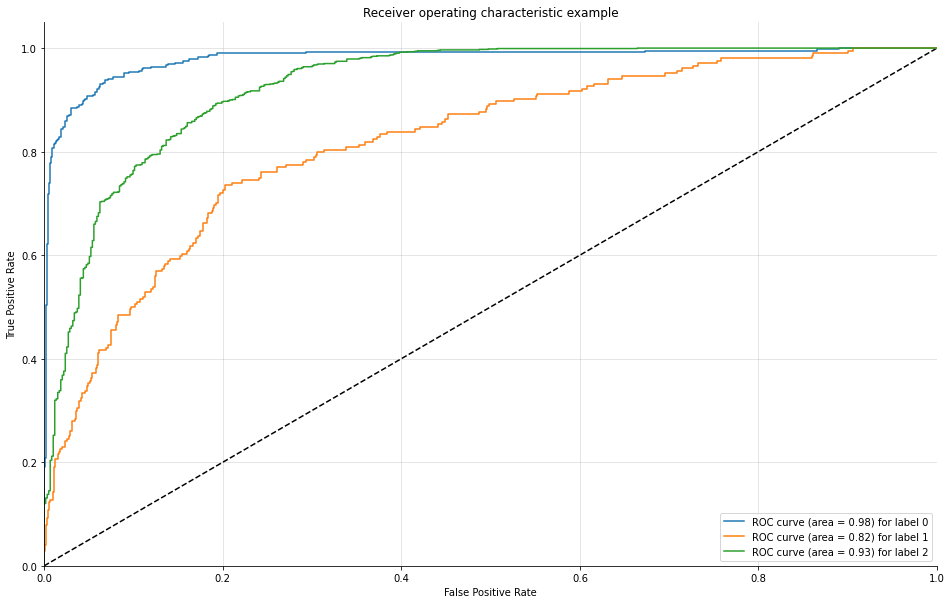

In [146]:
plot_multiclass_roc_for_tree(xgb_grid_model, 
                             X_test, 
                             y_test, 
                             n_classes=3, 
                             figsize=(16, 10))

In [147]:
xgb_feature_imp = pd.DataFrame(index = X.columns, data = xgb.feature_importances_,
                              columns = ["Feature Importance"]).sort_values("Feature Importance", ascending = False)
xgb_feature_imp

,Feature Importance
Gender,0.060
elbowrestheight,0.048
buttockpopliteallength,0.041
sittingheight,0.032
buttockkneelength,0.030
...,...
functionalleglength,0.005
shouldercircumference,0.005
bideltoidbreadth,0.004
lowerthighcircumference,0.004


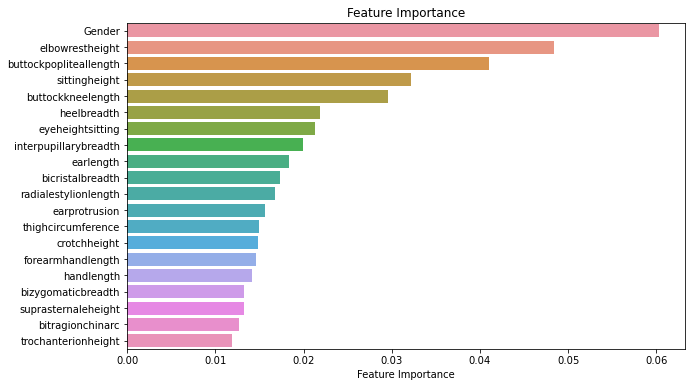

In [148]:
# 20 Most important features
sns.barplot(x=xgb_feature_imp["Feature Importance"].head(20), y=xgb_feature_imp.index[:20])
plt.title("Feature Importance")
plt.show()

## Compare Models

In [149]:
compare = pd.DataFrame({"Model": ["Logistic", "Log_Grid", "KNN", "SVC", "SVC_Grid",
                                  "RF", "RF_Grid", "XGB", "XGB_Grid"],
                        "F1": [log_f1, log_grid_f1, knn_f1 , svc_f1, svc_grid_f1,
                               rf_f1, rf_grid_f1, xgb_f1, xgb_grid_f1],
                        "Recall": [log_recall, log_grid_recall, knn_recall,
                                   svc_recall, svc_grid_recall,rf_recall,
                                   rf_grid_recall, xgb_recall, xgb_grid_recall]})

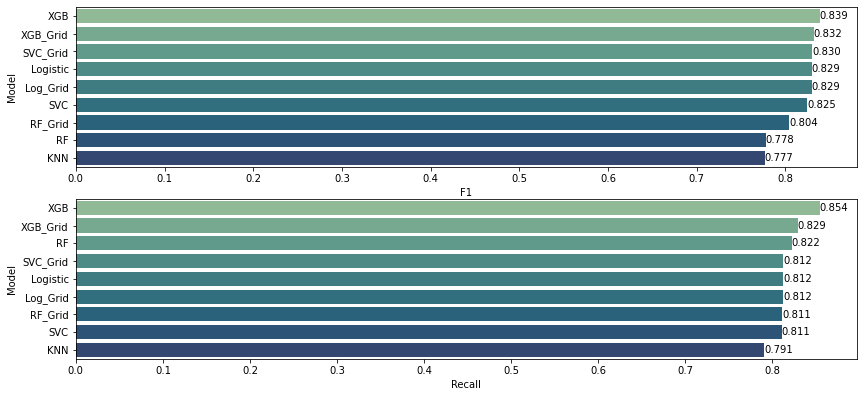

In [151]:
def labels(ax):
    for p in ax.patches:
        width = p.get_width()                        # get bar length
        ax.text(width,                               # set the text at 1 unit right of the bar
                p.get_y() + p.get_height() / 2,      # get Y coordinate + X coordinate / 2
                '{:1.3f}'.format(width),             # set variable to display, 2 decimals
                ha = 'left',                         # horizontal alignment
                va = 'center')                       # vertical alignment
    
plt.figure(figsize=(14,10))
plt.subplot(311)
compare = compare.sort_values(by="F1", ascending=False)
ax=sns.barplot(x="F1", y="Model", data=compare, palette="crest")
labels(ax)

plt.subplot(312)
compare = compare.sort_values(by="Recall", ascending=False)
ax=sns.barplot(x="Recall", y="Model", data=compare, palette="crest")
labels(ax)

---
---